In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder,StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# !pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier, XGBRegressor, plot_importance


from tabulate import tabulate
import seaborn as sns

In [ ]:
# 1. read CSV
df = pd.read_csv('/content/drive/MyDrive/XAI_DATA/MachineLearningCVE/CIC2017.csv',encoding='utf-8')

# 2. show the sample data
# print("data sample：")
# print(df.head())

# 3. basic info
# print("\nbasic info：")
# print(df.describe(include='all'))

# handle NaN
print(df.info())
features=df.columns.tolist()
print(features)
results = []
for col in df.columns:
  nunique = df[col].nunique(dropna=False)
  na_count = df[col].isna().sum()
  sample_values = df[col].dropna().sample(min(3, len(df)), replace=True).tolist()

  results.append({
            'Column': col,
            'Type': df[col].dtype,
            'Unique Values': nunique,
            'Missing Values': na_count,
            'Sample Values': sample_values[:3]
        })
print(tabulate(
        [(r['Column'], r['Type'], r['Unique Values'],
         f"{r['Missing Values']:,}", str(r['Sample Values']))
        for r in results],
        headers=['column', 'type', 'unique', 'missing', 'sample'],
        tablefmt='grid',
        numalign="right"
    ))

# object
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Object（{len(object_cols)}）：\n{object_cols}")

analysis_report = pd.DataFrame({
        'column': object_cols,
        'unique': [df[col].nunique() for col in object_cols],
        'Nan': [df[col].isnull().sum() for col in object_cols],
        'Nan rate': [df[col].isnull().mean().round(4) for col in object_cols],
        'frequency': [df[col].mode()[0] if not df[col].empty else np.nan for col in object_cols],
        'frequency rate': [round(df[col].value_counts(normalize=True).iloc[0], 4) for col in object_cols],
        'sample': [df[col].dropna().iloc[0] if not df[col].dropna().empty else np.nan for col in object_cols]
})

print("\nObject：")
display(analysis_report.sort_values('unique', ascending=False))

for col in object_cols:
    value_counts = df[col].value_counts(dropna=False)
    unique_count = len(value_counts)

    print(f"\n=== column【{col}】 ===")
    print(f"unique{unique_count}")
    print(value_counts.head(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

,column,unique,Nan,Nan rate,frequency,frequency rate,sample
0,Label,15,0,0.0,BENIGN,0.803,BENIGN



=== column【 Label】 ===
unique15
 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [ ]:
df['Flow Bytes/s'] = df['Flow Bytes/s'].replace([np.inf, -np.inf], 1e11)
df[' Flow Packets/s'] = df[' Flow Packets/s'].replace([np.inf, -np.inf], 1e8)
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Object类型列（共{len(object_cols)}个）：\n{object_cols}")
unique_columns=[item['Column'] for item in results if item['Unique Values'] == 1]
print(unique_columns)
df_cleaned = df.drop(unique_columns, axis=1)
df_cleaned = df_cleaned.dropna(axis=0)

original_labels = [
    "Web Attack � Brute Force",
    "Web Attack � XSS",
    "Infiltration                      ",  # 保留尾部空格
    "Web Attack � Sql Injection",
    "Heartbleed"
]
replace_dict = {lb: "Web Attack" for lb in original_labels}
df_cleaned[' Label'] = df[' Label'].replace(replace_dict)

print(df_cleaned.info())

Object类型列（共1个）：
[' Label']
[' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
<class 'pandas.core.frame.DataFrame'>
Index: 2829385 entries, 0 to 2830742
Data columns (total 71 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 1

In [ ]:
features=df_cleaned.columns.tolist()
features.remove(' Label')
print(features)
X = df_cleaned[features]
y = df_cleaned[' Label']
le = LabelEncoder()
y = le.fit_transform(y)

[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count', ' ECE Fla

After having a total view of the dataset, the next step will be using different ML model to build the detection system.
Here we choose different models:

1.   Decision Trees
2.   Random Forests

1.   Multilayer Perceptron
2.   DNN

1.   XGBoost






Test Accuracy: 0.20

Classification Report:
                  precision    recall  f1-score   support

          BENIGN       1.00      0.08      0.15    681807
             Bot       0.01      1.00      0.01       590
            DDoS       0.50      1.00      0.66     38408
   DoS GoldenEye       0.06      0.72      0.10      3088
        DoS Hulk       0.10      0.33      0.15     69037
DoS Slowhttptest       0.00      0.06      0.01      1650
   DoS slowloris       0.01      0.98      0.01      1739
     FTP-Patator       0.75      1.00      0.86      2381
    Infiltration       0.91      0.91      0.91        11
        PortScan       0.67      0.93      0.78     47679
     SSH-Patator       0.70      1.00      0.82      1769
      Web Attack       0.33      0.92      0.49       657

        accuracy                           0.20    848816
       macro avg       0.42      0.74      0.41    848816
    weighted avg       0.87      0.20      0.21    848816



<Figure size 2500x1500 with 0 Axes>

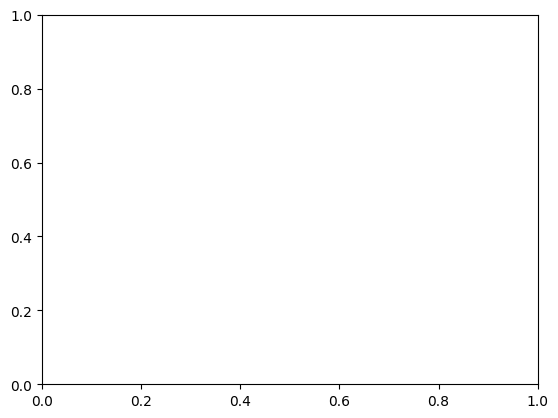

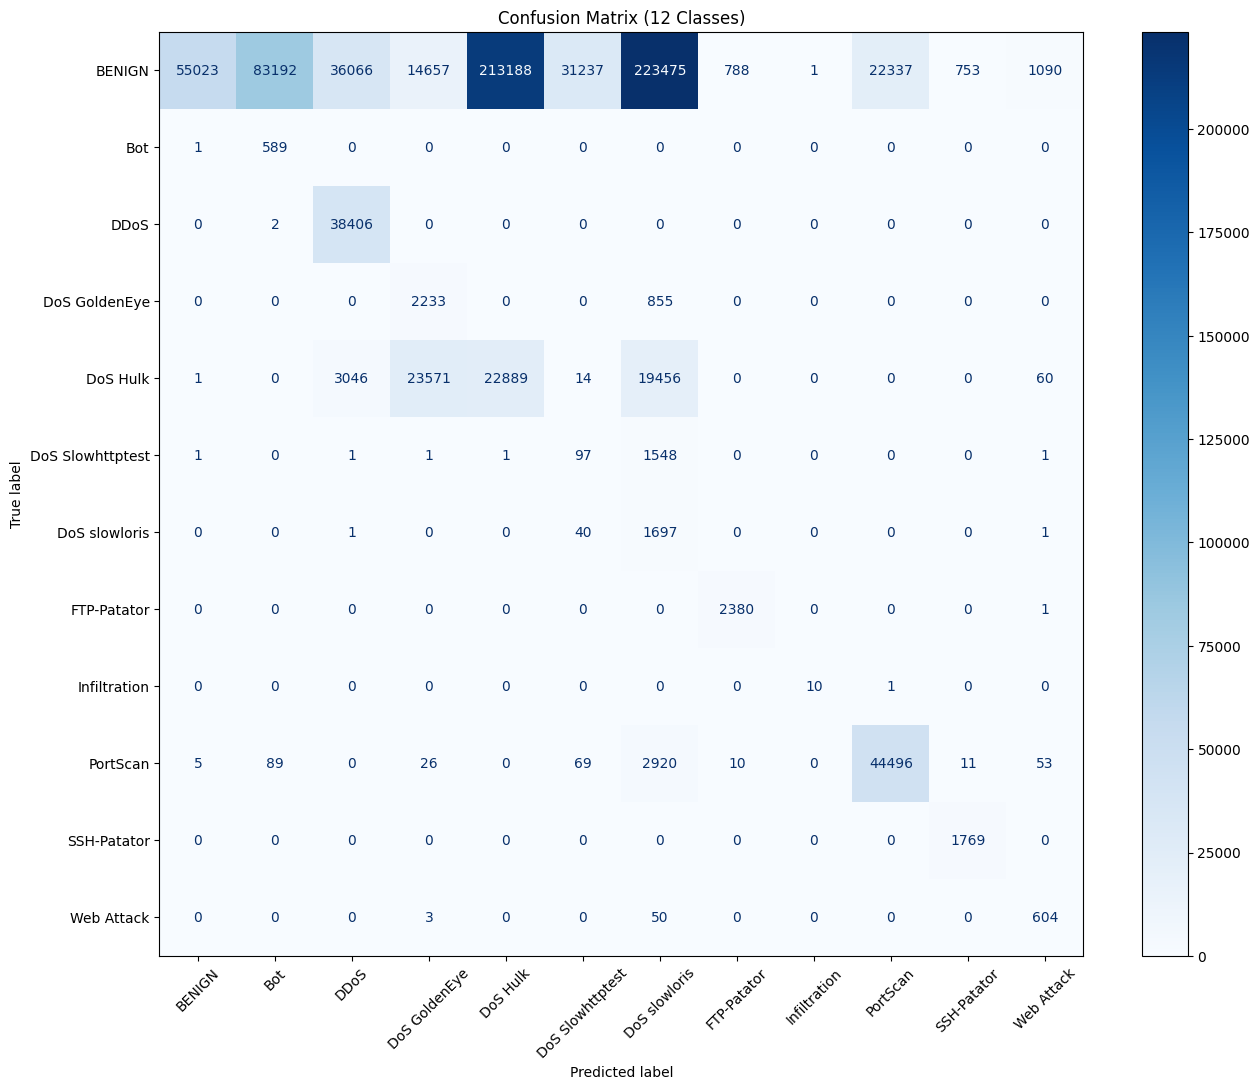


Top 10 Features:
 Destination Port              0.519169
 Init_Win_bytes_backward       0.116046
 min_seg_size_forward          0.088937
 Fwd Packet Length Max         0.068605
 Average Packet Size           0.067099
Bwd Packet Length Max          0.062326
Flow Bytes/s                   0.052803
 Packet Length Mean            0.013488
Total Length of Fwd Packets    0.005767
 Bwd Packet Length Min         0.002838
dtype: float64


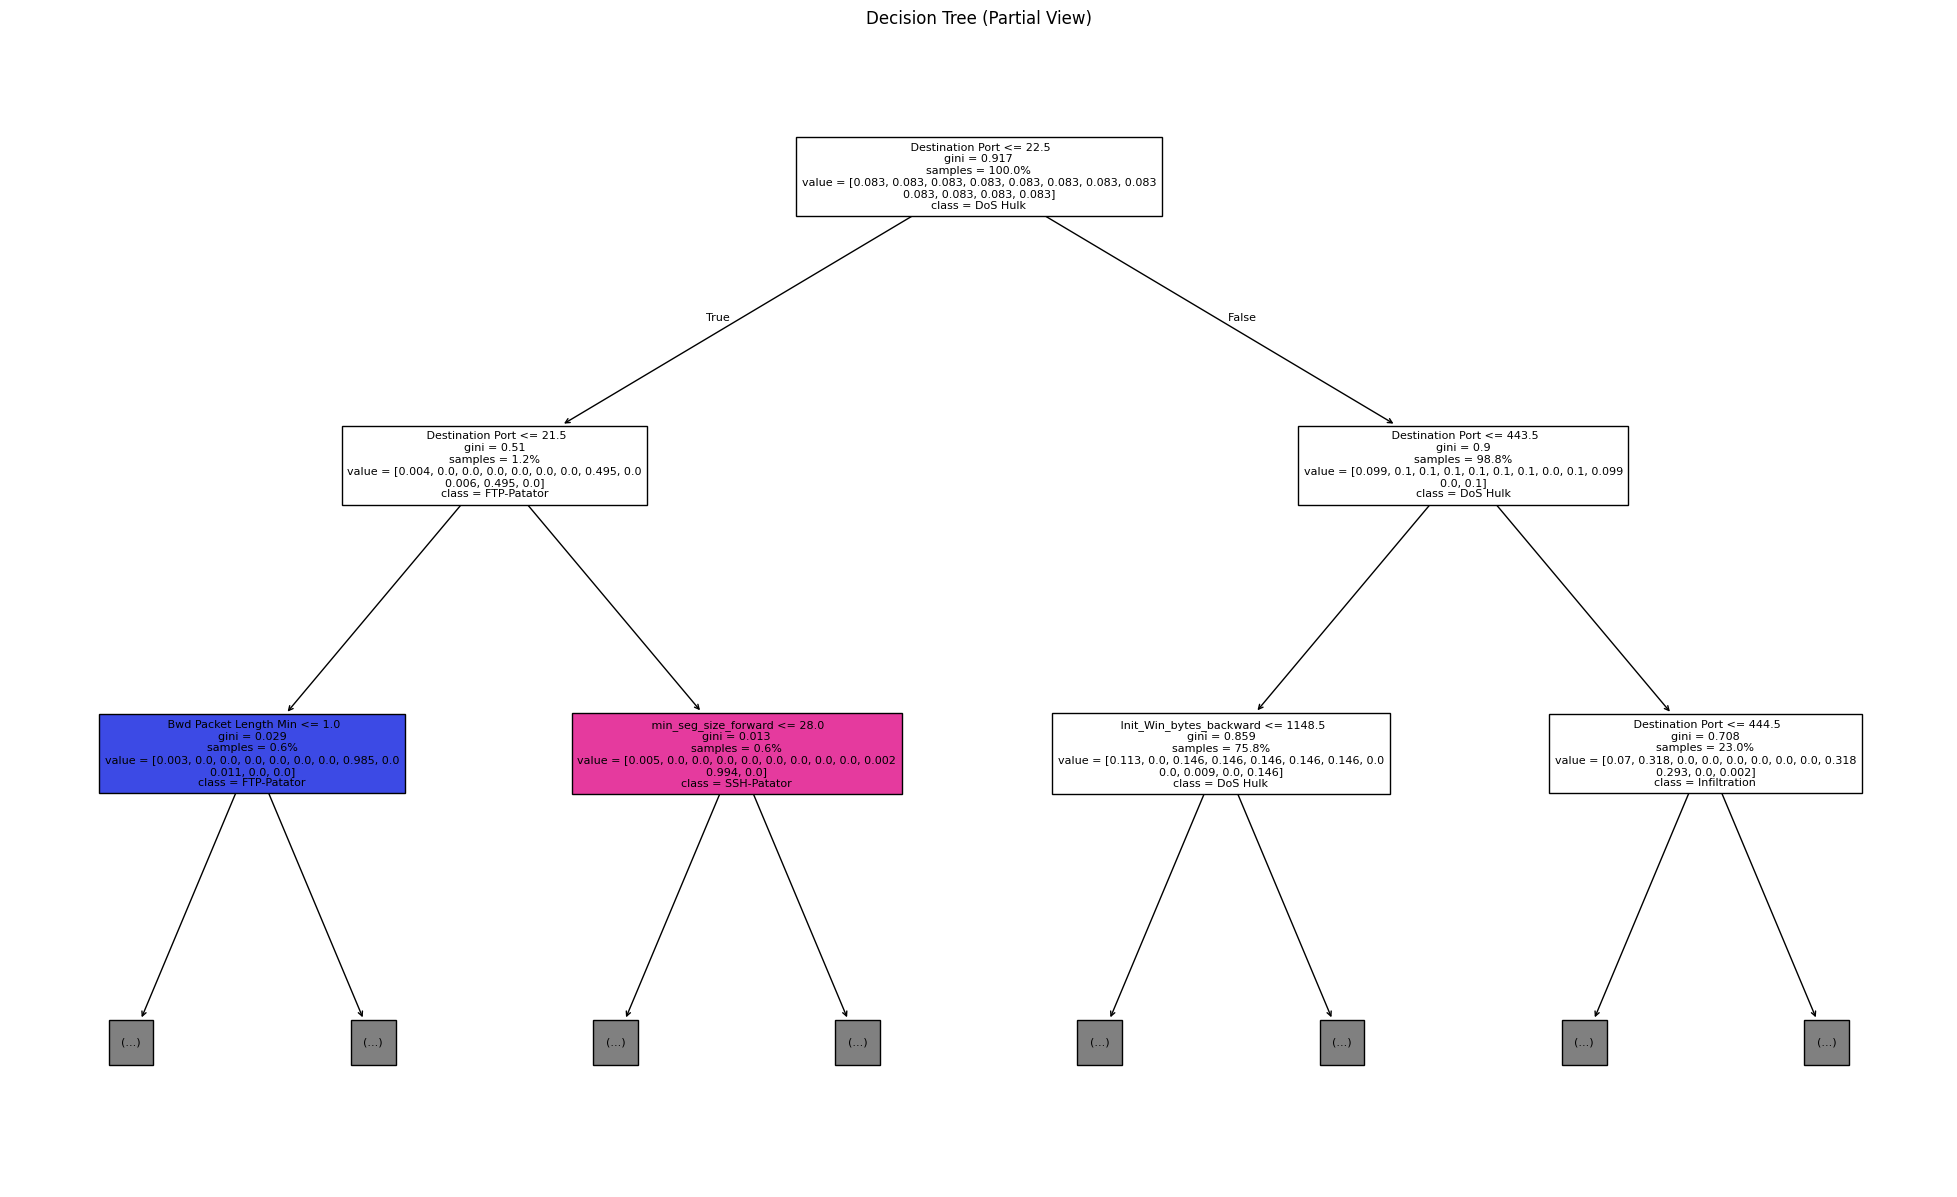

In [ ]:
#DT

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

# train model
clf.fit(X_train, y_train)

# prediction
y_pred = clf.predict(X_test)

# evaluation
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}\n")

class_names = le.classes_.tolist()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

fig, ax = plt.subplots(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (12 Classes)")
plt.show()

# feature importance
feature_importance = pd.Series(clf.feature_importances_, index=features)
feature_importance = feature_importance.sort_values(ascending=False)
print("\nTop 10 Features:")
print(feature_importance.head(10))

# plot
plt.figure(figsize=(25, 15))
# Ensure you are calling the correct plot_tree from sklearn.tree
plot_tree(
    clf,
    filled=True,
    feature_names=features,
    class_names=class_names,
    max_depth=2,
    fontsize=8,
    proportion=True
)
plt.title("Decision Tree (Partial View)")
plt.show()

树模型XAI分析器已准备就绪。

--- 正在生成SHAP Summary Plots ---
正在创建SHAP TreeExplainer...
计算完成。模型期望值: [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
正在为 200 个样本计算SHAP值...

[SHAP] 正在生成 Beeswarm Plot...
图表已保存至: xai_reports_tree/SHAP_Summary_Beeswarm.png


<Figure size 640x480 with 0 Axes>

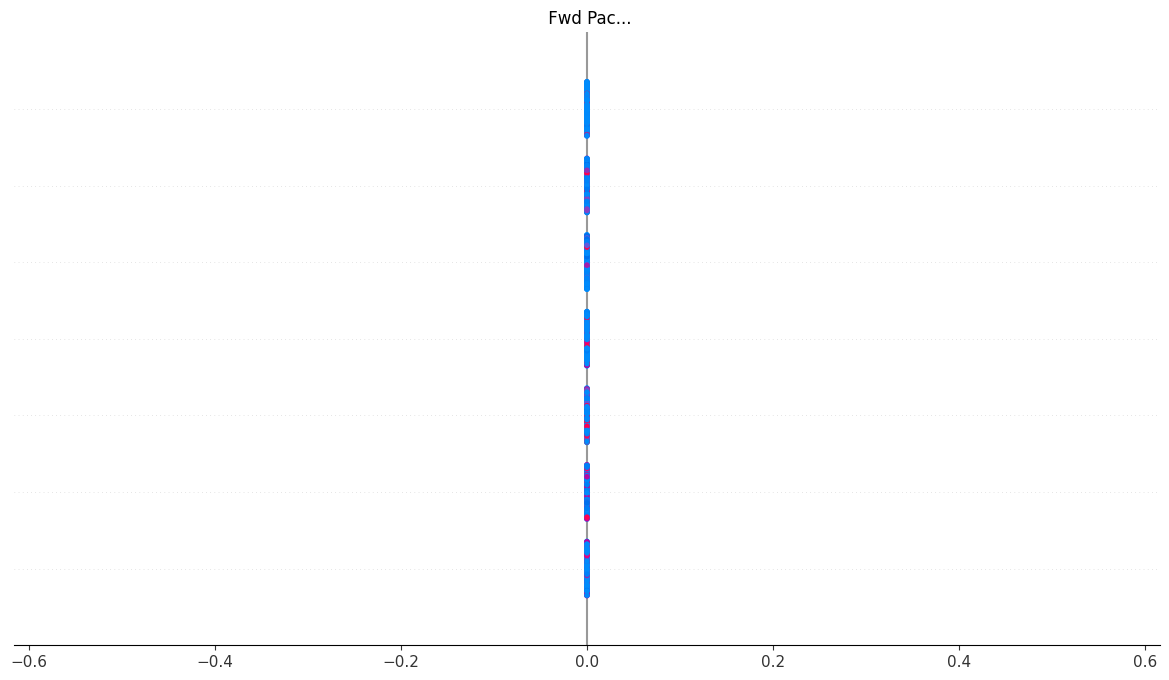


[SHAP] 正在生成 Bar Plot...
图表已保存至: xai_reports_tree/SHAP_Summary_Bar.png


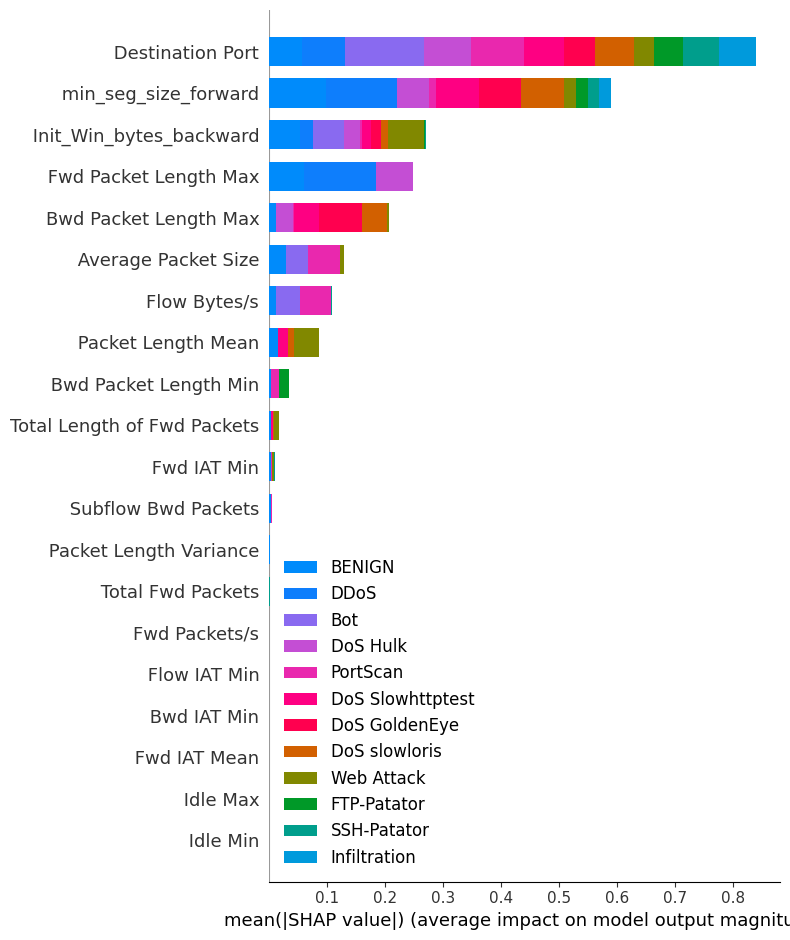


--- 正在分析模型预测结果 ---
总样本数: 848816; ✅ 正确: 170193; ❌ 错误: 678623; 准确率: 20.05%

--- 将对前 3 个错误预测样本进行深度分析 ---

========================= 分析样本: Wrong Sample 1 (True BENIGN, Pred Bot) =========================
模型预测结果: 'Bot' (概率: 0.7494)

[SHAP] 正在生成 Waterfall Plot...
图表已保存至: xai_reports_tree/Wrong Sample 1 True BENIGN Pred Bot_SHAP_Waterfall.png


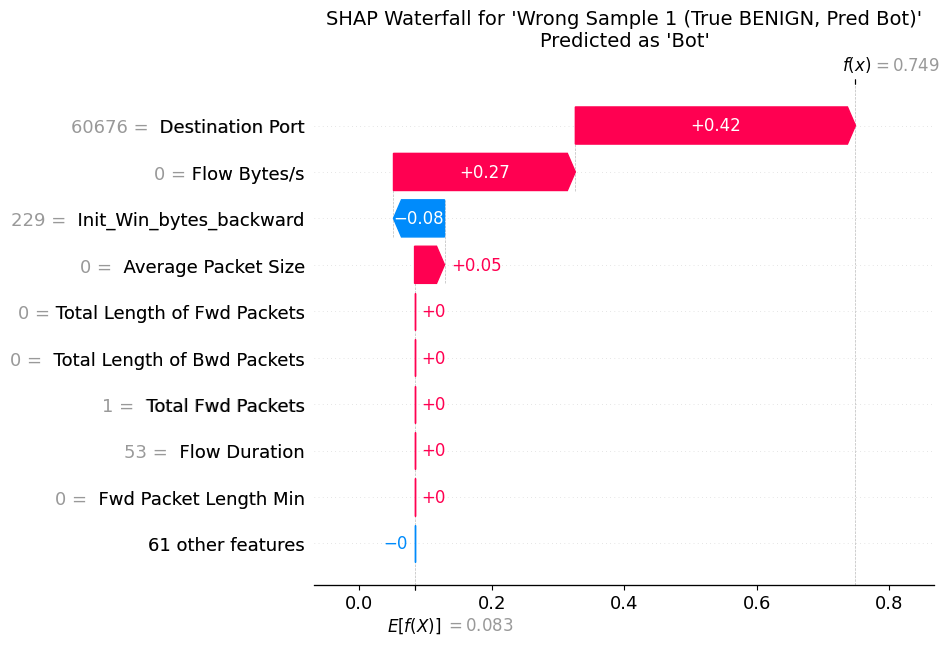


[SHAP] 正在生成 Force Plot (交互式)...



[LIME] 正在生成解释...
正在创建LIME TabularExplainer...
[LIME] 将为类别 ['BENIGN', 'Bot'] 生成解释。

[LIME] 可读性增强版文本摘要:



========================= 分析样本: Wrong Sample 2 (True BENIGN, Pred DoS slowloris) =========================
模型预测结果: 'DoS slowloris' (概率: 0.3261)

[SHAP] 正在生成 Waterfall Plot...
图表已保存至: xai_reports_tree/Wrong Sample 2 True BENIGN Pred DoS slowloris_SHAP_Waterfall.png


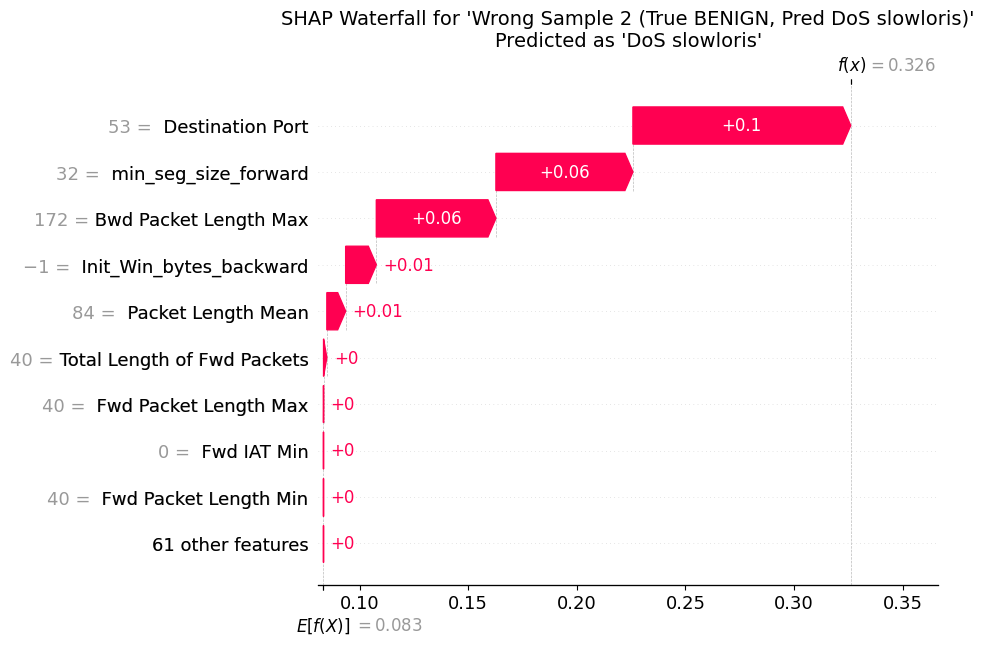


[SHAP] 正在生成 Force Plot (交互式)...



[LIME] 正在生成解释...
[LIME] 将为类别 ['BENIGN', 'DoS slowloris'] 生成解释。

[LIME] 可读性增强版文本摘要:



========================= 分析样本: Wrong Sample 4 (True DoS Hulk, Pred DoS GoldenEye) =========================
模型预测结果: 'DoS GoldenEye' (概率: 0.6567)

[SHAP] 正在生成 Waterfall Plot...
图表已保存至: xai_reports_tree/Wrong Sample 4 True DoS Hulk Pred DoS GoldenEye_SHAP_Waterfall.png


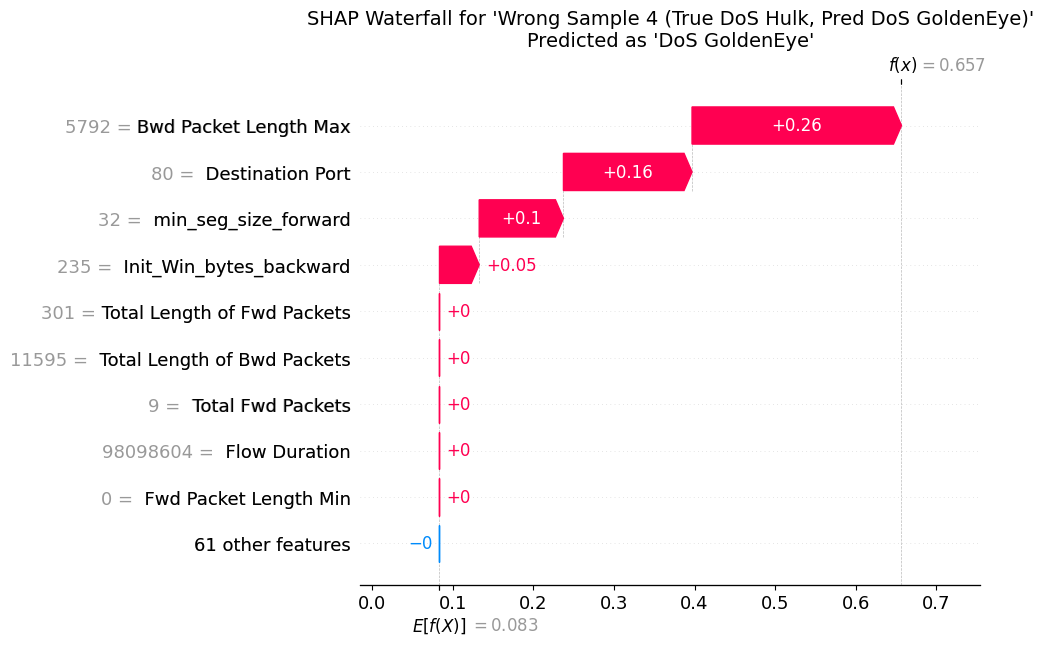


[SHAP] 正在生成 Force Plot (交互式)...



[LIME] 正在生成解释...
[LIME] 将为类别 ['DoS GoldenEye', 'DoS Hulk'] 生成解释。

[LIME] 可读性增强版文本摘要:



### 所有分析已完成！ ###


In [ ]:
shap.initjs()

# 3.2: 实例化新的TreeXAIAnalyzer
# 注意：我们不再传入scaler，因为我们没有使用它
tree_analyzer = TreeXAIAnalyzer(
    model=clf,
    X_train=X_train,
    class_names=le.classes_.tolist(),
    feature_names=features
    # scaler=None 是默认值，无需填写
)
print("树模型XAI分析器已准备就绪。")

# 3.3: 进行调用
# (A) 分析全局特征重要性
tree_analyzer.generate_shap_summary_plot(X_test, max_samples=200, save_plots_path="xai_reports_tree")

# (B) 分析错误预测的样本
tree_analyzer.analyze_wrong_predictions(X_test, y_test, max_samples=3, save_plots_path="xai_reports_tree")

print("\n### 所有分析已完成！ ###")

In [ ]:
import shap
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

class XAI_kernel_Analyzer:
    """
    XAI可解释性分析器，集成SHAP和LIME功能
    """

    def __init__(self, model, X_train: pd.DataFrame, class_names: List[str] = None):
        """
        初始化XAI分析器

        Args:
            model: 训练好的机器学习模型
            X_train: 训练数据特征
            class_names: 类别名称列表
        """
        self.model = model
        self.X_train = X_train
        self.class_names =class_names
        self.explainer = None
        self.lime_explainer = None

    def _create_shap_explainer(self, sample_size: int = 100):
        """创建SHAP解释器"""
        if self.explainer is None:
            sample_data = shap.sample(self.X_train, min(sample_size, len(self.X_train)))
            self.explainer = shap.KernelExplainer(self.model.predict, sample_data)
        return self.explainer

    def _create_lime_explainer(self):
        """创建LIME解释器"""
        if self.lime_explainer is None:
            self.lime_explainer = lime.lime_tabular.LimeTabularExplainer(
                training_data=self.X_train.values,
                feature_names=self.X_train.columns.tolist(),
                class_names=self.class_names,
                mode='classification'
            )
        return self.lime_explainer

    def generate_shap_summary_plots(self, X_test: pd.DataFrame, max_samples: int = 100):
        """
        生成SHAP总体分析图（bar plot和beeswarm plot）

        Args:
            X_test: 测试数据
            max_samples: 最大样本数量
        """
        print("正在生成SHAP总体分析图...")

        # 创建解释器
        explainer = self._create_shap_explainer()

        # 限制样本数量以提高性能
        test_sample = X_test.iloc[:min(max_samples, len(X_test))]

        # 计算SHAP值
        print(f"正在计算 {len(test_sample)} 个样本的SHAP值...")
        shap_values = explainer.shap_values(test_sample)

        # 生成summary plot - bar plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, test_sample, plot_type="bar", show=False)
        plt.title("SHAP Feature Importance (Bar Plot)", fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        # 生成summary plot - beeswarm plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, test_sample, show=False)
        plt.title("SHAP Feature Effects (Beeswarm Plot)", fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

        return shap_values

    def find_wrong_predictions(self, X_test: pd.DataFrame, y_test: pd.Series) -> Tuple[np.ndarray, np.ndarray]:
        """
        找出模型的错误预测

        Args:
            X_test: 测试特征
            y_test: 测试标签

        Returns:
            wrong_indices: 错误预测的索引
            y_pred: 所有预测结果
        """
        print("正在分析模型预测结果...")

        y_pred = self.model.predict(X_test)
        wrong_indices = np.where(y_pred != y_test)[0]

        print(f"总样本数: {len(y_test)}")
        print(f"错误预测数: {len(wrong_indices)}")
        print(f"错误率: {len(wrong_indices)/len(y_test):.2%}")

        if len(wrong_indices) > 0:
            print(f"错误预测样本索引: {wrong_indices[:10]}..." if len(wrong_indices) > 10 else f"错误预测样本索引: {wrong_indices}")

        return wrong_indices, y_pred

    def analyze_wrong_predictions_shap(self, X_test: pd.DataFrame, y_test: pd.Series,
                                     max_samples: int = 5, class_index: Optional[int] = None):
        """
        使用SHAP分析错误预测样本

        Args:
            X_test: 测试特征
            y_test: 测试标签
            max_samples: 分析的最大样本数
            class_index: 指定分析的类别索引（多分类时使用）
        """
        wrong_indices, y_pred = self.find_wrong_predictions(X_test, y_test)

        if len(wrong_indices) == 0:
            print("🎉 模型没有错误预测！")
            return

        print(f"\n📊 正在分析前 {min(max_samples, len(wrong_indices))} 个错误预测样本的SHAP解释...")

        # 创建解释器
        explainer = self._create_shap_explainer()

        # 选择要分析的样本
        sample_indices = wrong_indices[:max_samples] if len(wrong_indices) > max_samples else wrong_indices
        X_wrong = X_test.iloc[sample_indices]

        # 计算SHAP值
        shap_values = explainer.shap_values(X_wrong)

        # 为每个错误样本生成waterfall图
        for i, idx in enumerate(sample_indices):
            self._plot_single_shap_waterfall(explainer, shap_values, X_test, y_test,
                                           y_pred, idx, i, class_index)

    def _plot_single_shap_waterfall(self, explainer, shap_values, X_test, y_test,
                                  y_pred, idx, i, class_index):
        """绘制单个样本的SHAP waterfall图"""
        print(f"\n样本 {idx}:")
        print(f"真实标签: {y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]} ({self.class_names[y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]]})")
        print(f"预测标签: {y_pred[idx]} ({self.class_names[y_pred[idx]]})")

        # 处理多分类和二分类情况
        if isinstance(shap_values, list):
            # 多分类模型
            target_class = class_index if class_index is not None else y_pred[idx]
            values = shap_values[target_class][i]
            base_value = explainer.expected_value[target_class]
            plot_title = f"样本 {idx} - {self.class_names[target_class]} 类别的SHAP解释"
        else:
            # 二分类模型
            values = shap_values[i]
            base_value = explainer.expected_value
            plot_title = f"样本 {idx} - SHAP解释"

        # 创建解释对象
        explanation = shap.Explanation(
            values=values,
            base_values=base_value,
            data=X_test.iloc[idx],
            feature_names=X_test.columns.tolist()
        )

        # 绘制waterfall图
        plt.figure(figsize=(12, 8))
        shap.waterfall_plot(explanation, show=False)
        plt.title(plot_title, fontsize=14, pad=20)
        plt.tight_layout()
        plt.show()

    def analyze_wrong_predictions_lime(self, X_test: pd.DataFrame, y_test: pd.Series,
                                     max_samples: int = 5, num_features: int = 10):
        """
        使用LIME分析错误预测样本

        Args:
            X_test: 测试特征
            y_test: 测试标签
            max_samples: 分析的最大样本数
            num_features: LIME解释中显示的特征数量
        """
        wrong_indices, y_pred = self.find_wrong_predictions(X_test, y_test)

        if len(wrong_indices) == 0:
            print("🎉 模型没有错误预测！")
            return

        print(f"\n🔍 正在分析前 {min(max_samples, len(wrong_indices))} 个错误预测样本的LIME解释...")

        # 创建LIME解释器
        lime_explainer = self._create_lime_explainer()

        # 选择要分析的样本
        sample_indices = wrong_indices[:max_samples] if len(wrong_indices) > max_samples else wrong_indices

        # 为每个错误样本生成LIME解释
        for idx in sample_indices:
            print(f"\n--- 样本 {idx} 的LIME解释 ---")
            print(f"真实标签: {y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]} ({self.class_names[y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]]})")
            print(f"预测标签: {y_pred[idx]} ({self.class_names[y_pred[idx]]})")

            # 检查模型是否有predict_proba方法
            if hasattr(self.model, 'predict_proba'):
                prediction_fn = self.model.predict_proba
            else:
                # 如果没有predict_proba，创建一个包装函数
                def prediction_fn(X):
                    preds = self.model.predict(X)
                    # 转换为概率格式（简单的one-hot编码）
                    proba = np.zeros((len(preds), len(self.class_names)))
                    for i, pred in enumerate(preds):
                        proba[i, pred] = 1.0
                    return proba

            try:
                # 生成LIME解释
                exp = lime_explainer.explain_instance(
                    X_test.iloc[idx].values,
                    prediction_fn,
                    num_features=min(num_features, len(X_test.columns))
                )

                # 显示解释
                exp.show_in_notebook(show_table=True)

                # 也可以保存为图片（可选）
                # fig = exp.as_pyplot_figure()
                # plt.title(f'LIME解释 - 样本 {idx}')
                # plt.tight_layout()
                # plt.show()

            except Exception as e:
                print(f"生成样本 {idx} 的LIME解释时出错: {str(e)}")

    def complete_xai_analysis(self, X_test: pd.DataFrame, y_test: pd.Series,
                            max_summary_samples: int = 100, max_wrong_samples: int = 5,
                            lime_features: int = 10, class_index: Optional[int] = None):
        """
        完整的XAI分析流程

        Args:
            X_test: 测试特征
            y_test: 测试标签
            max_summary_samples: 生成总体图的最大样本数
            max_wrong_samples: 分析错误预测的最大样本数
            lime_features: LIME解释显示的特征数
            class_index: 多分类时指定分析的类别
        """
        print("🚀 开始完整的XAI可解释性分析...")
        print("=" * 60)

        # 1. 生成SHAP总体分析图
        print("📈 第一步: 生成SHAP总体分析图")
        self.generate_shap_summary_plots(X_test, max_summary_samples)

        print("\n" + "=" * 60)

        # 2. 分析错误预测 - SHAP
        print("🔍 第二步: 使用SHAP分析错误预测")
        self.analyze_wrong_predictions_shap(X_test, y_test, max_wrong_samples, class_index)

        print("\n" + "=" * 60)

        # 3. 分析错误预测 - LIME
        print("🔍 第三步: 使用LIME分析错误预测")
        self.analyze_wrong_predictions_lime(X_test, y_test, max_wrong_samples, lime_features)

        print("\n" + "=" * 60)
        print("✅ XAI分析完成！")



In [ ]:
# 使用示例
# 1. 创建分析器
analyzer = XAIAnalyzer(clf, X_train, class_names=le.classes_.tolist())

# 2. 执行完整分析（推荐）
analyzer.complete_xai_analysis(X_test, y_test)


Output hidden; open in https://colab.research.google.com to view.

Test Accuracy: 0.9684

Classification Report:
                  precision    recall  f1-score   support

          BENIGN       1.00      0.96      0.98    681807
             Bot       0.05      0.99      0.09       590
            DDoS       1.00      1.00      1.00     38408
   DoS GoldenEye       0.90      0.99      0.95      3088
        DoS Hulk       0.86      1.00      0.92     69037
DoS Slowhttptest       0.94      0.99      0.96      1650
   DoS slowloris       0.99      1.00      0.99      1739
     FTP-Patator       1.00      1.00      1.00      2381
    Infiltration       1.00      0.64      0.78        11
        PortScan       0.99      1.00      1.00     47679
     SSH-Patator       0.91      1.00      0.95      1769
      Web Attack       0.28      0.99      0.43       657

        accuracy                           0.97    848816
       macro avg       0.83      0.96      0.84    848816
    weighted avg       0.99      0.97      0.98    848816



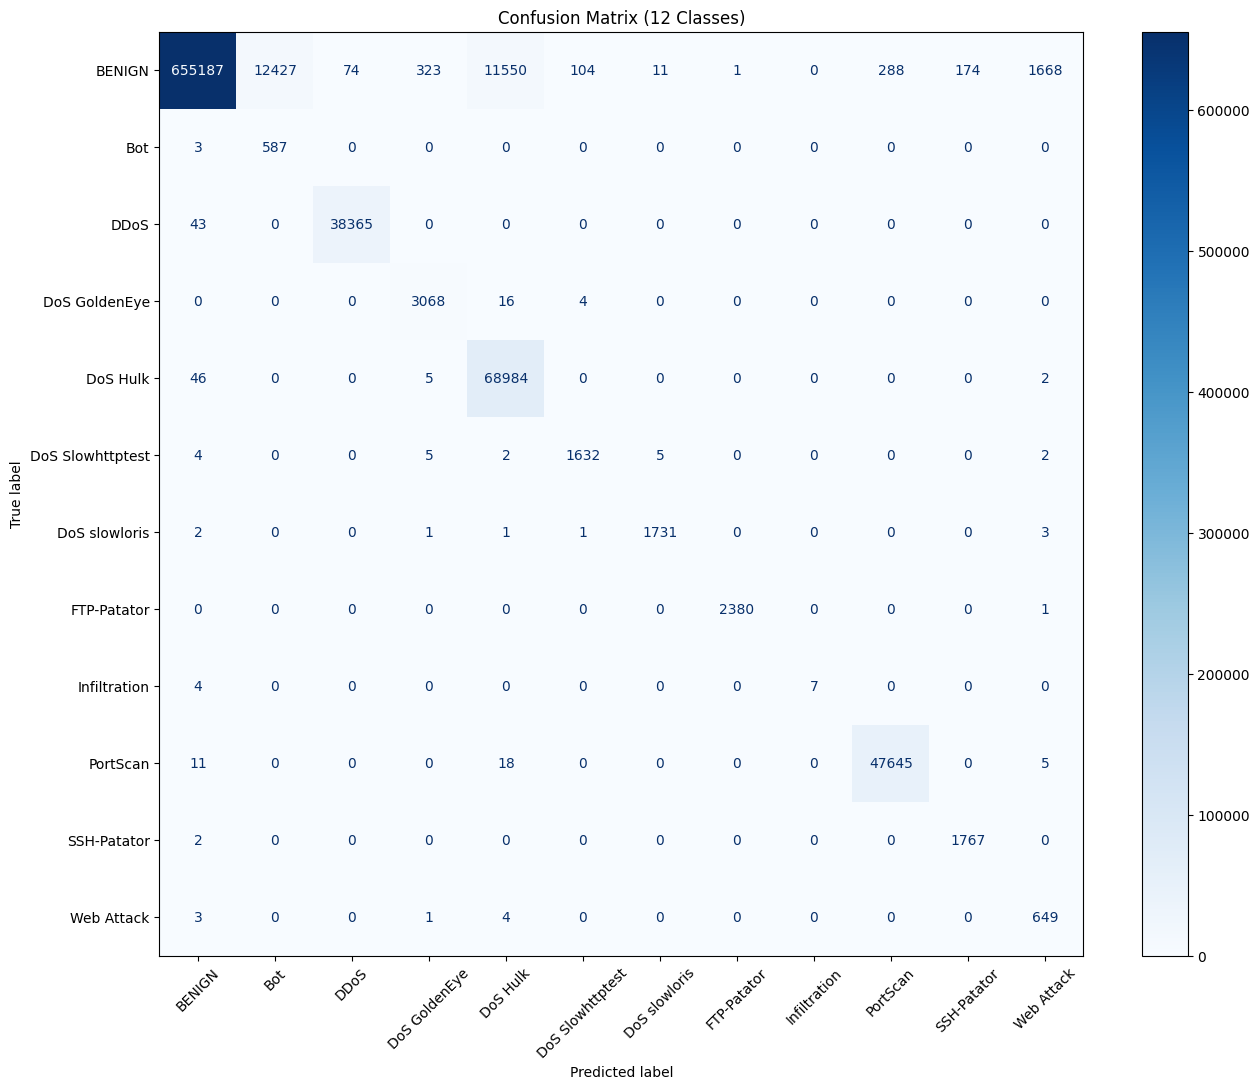

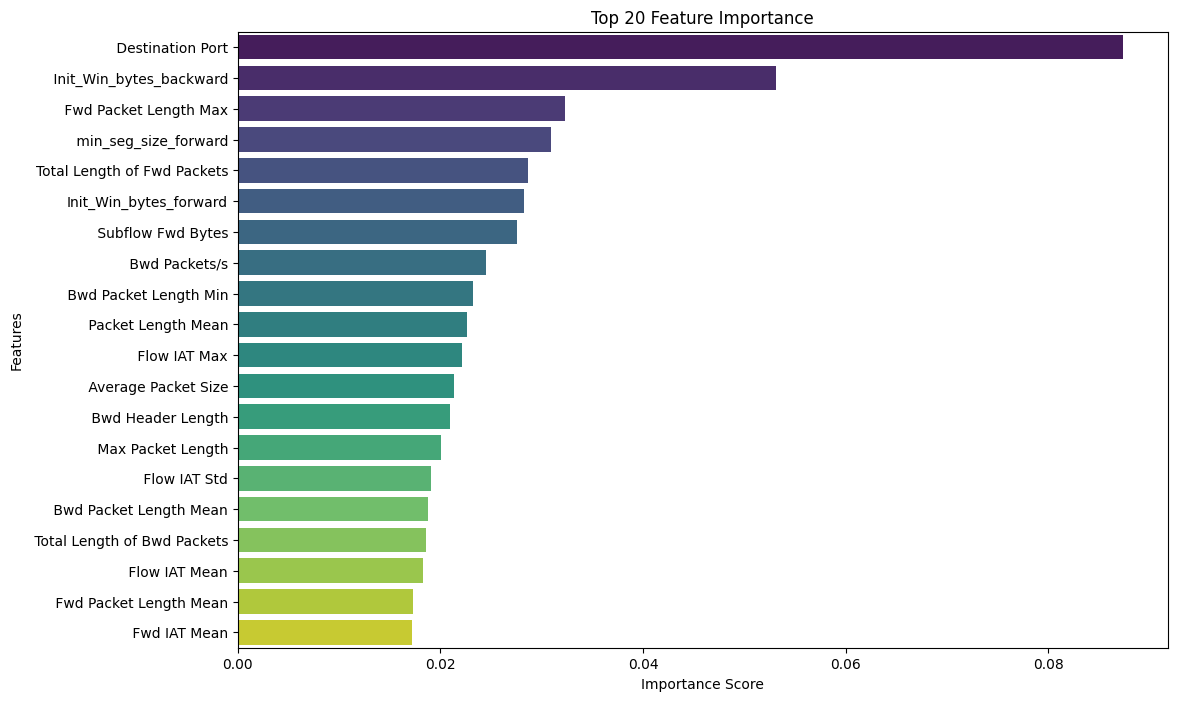

In [ ]:
#RF

rf_clf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# train
rf_clf.fit(X_train, y_train)

# prediction
y_pred = rf_clf.predict(X_test)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

class_names = le.classes_.tolist()
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

fig, ax = plt.subplots(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (12 Classes)")
plt.show()

# feature importance
feature_importance = pd.Series(
    rf_clf.feature_importances_,
    index=features
).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20], palette="viridis")
plt.title("Top 20 Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [ ]:
# 使用示例
# 1. 创建分析器
analyzer = XAIAnalyzer(rf_clf, X_train, class_names=le.classes_.tolist())

# 2. 执行完整分析（推荐）
analyzer.complete_xai_analysis(X_test, y_test)


Output hidden; open in https://colab.research.google.com to view.

树模型XAI分析器已准备就绪。

--- 正在生成SHAP Summary Plots ---
正在创建SHAP TreeExplainer...
计算完成。模型期望值: [0.08334847 0.08338933 0.08335959 0.08345313 0.08335651 0.08330917
 0.08333038 0.08341638 0.08280966 0.08338992 0.08324809 0.08358938]
正在为 200 个样本计算SHAP值...

[SHAP] 正在生成 Beeswarm Plot...
图表已保存至: xai_reports_tree/SHAP_Summary_Beeswarm.png


<Figure size 640x480 with 0 Axes>

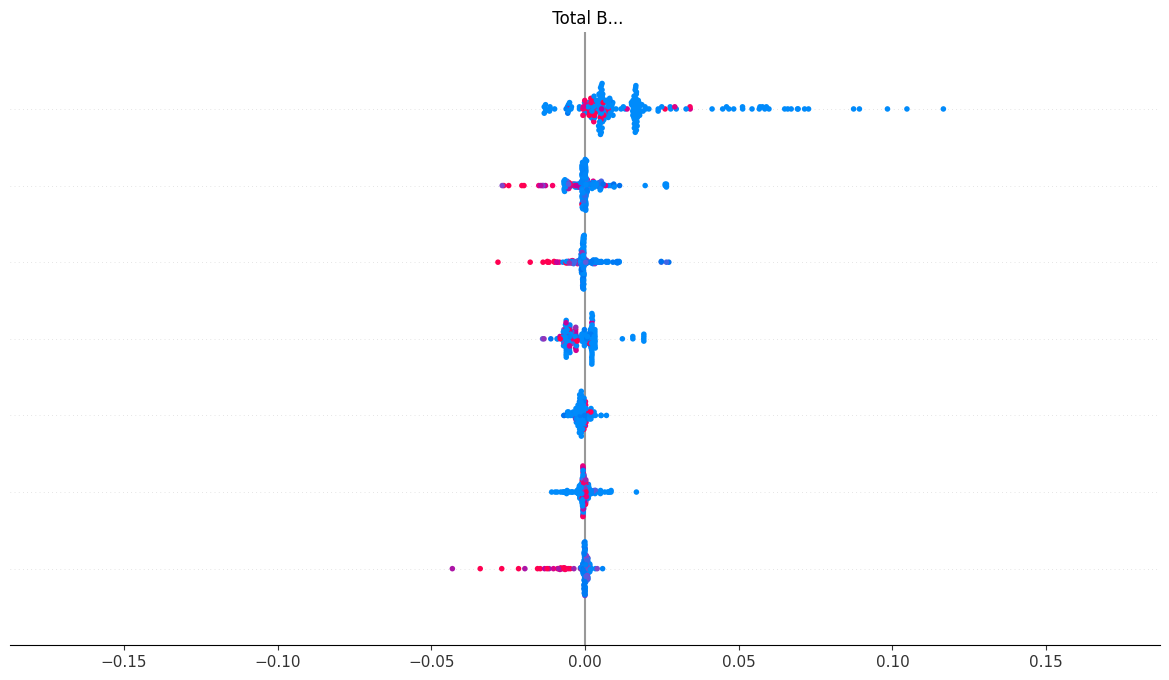


[SHAP] 正在生成 Bar Plot...
图表已保存至: xai_reports_tree/SHAP_Summary_Bar.png


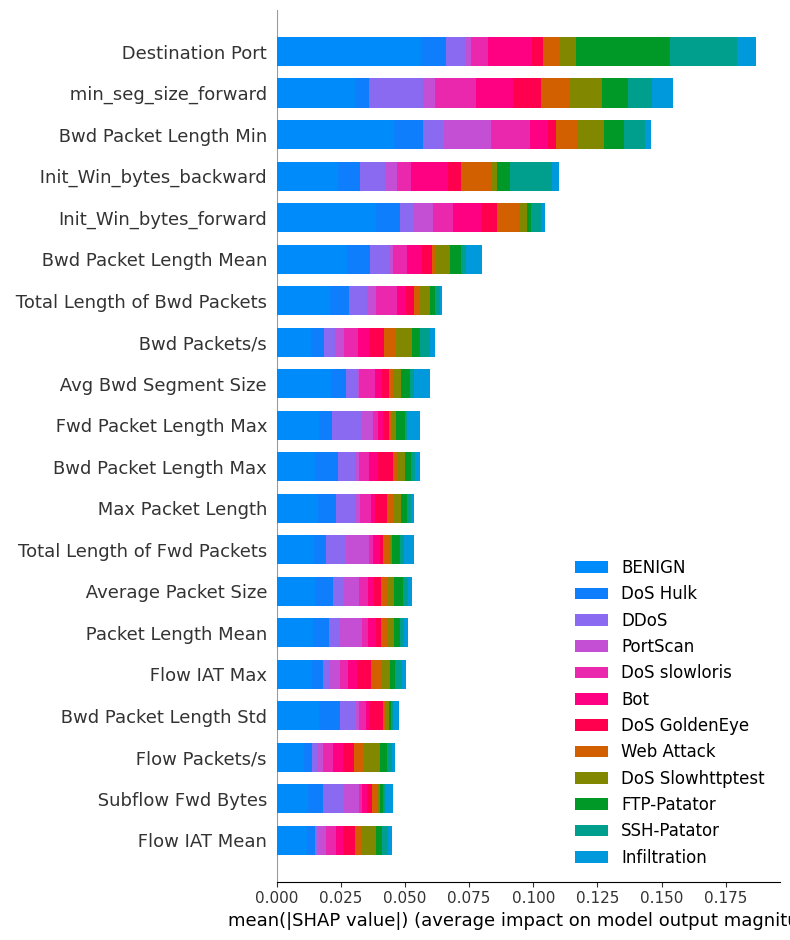


--- 正在分析模型预测结果 ---
总样本数: 848816; ✅ 正确: 822002; ❌ 错误: 26814; 准确率: 96.84%

--- 将对前 3 个错误预测样本进行深度分析 ---

========================= 分析样本: Wrong Sample 29 (True BENIGN, Pred Bot) =========================
模型预测结果: 'Bot' (概率: 0.9277)

[SHAP] 正在生成 Waterfall Plot...
图表已保存至: xai_reports_tree/Wrong Sample 29 True BENIGN Pred Bot_SHAP_Waterfall.png


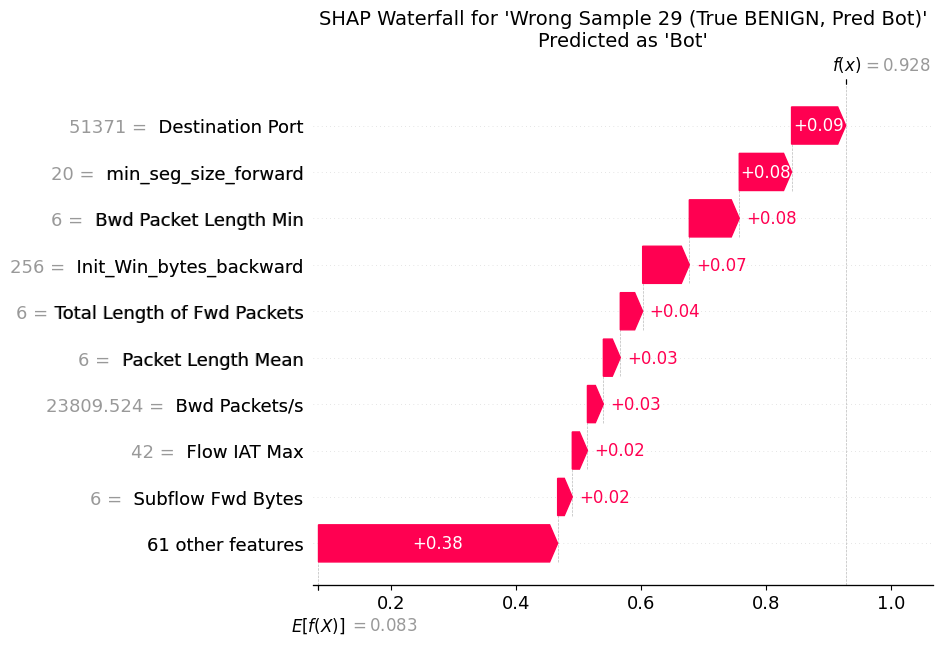


[SHAP] 正在生成 Force Plot (交互式)...



[LIME] 正在生成解释...
正在创建LIME TabularExplainer...
[LIME] 将为类别 ['BENIGN', 'Bot'] 生成解释。

[LIME] 可读性增强版文本摘要:



========================= 分析样本: Wrong Sample 45 (True BENIGN, Pred Bot) =========================
模型预测结果: 'Bot' (概率: 0.9118)

[SHAP] 正在生成 Waterfall Plot...
图表已保存至: xai_reports_tree/Wrong Sample 45 True BENIGN Pred Bot_SHAP_Waterfall.png


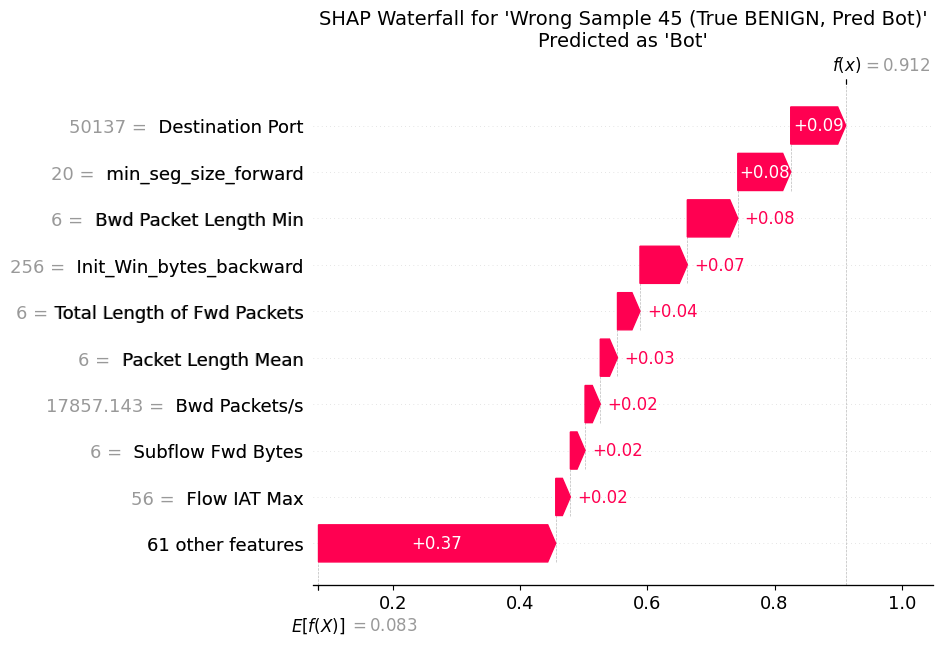


[SHAP] 正在生成 Force Plot (交互式)...



[LIME] 正在生成解释...
[LIME] 将为类别 ['BENIGN', 'Bot'] 生成解释。

[LIME] 可读性增强版文本摘要:



========================= 分析样本: Wrong Sample 53 (True BENIGN, Pred Bot) =========================
模型预测结果: 'Bot' (概率: 0.5077)

[SHAP] 正在生成 Waterfall Plot...
图表已保存至: xai_reports_tree/Wrong Sample 53 True BENIGN Pred Bot_SHAP_Waterfall.png


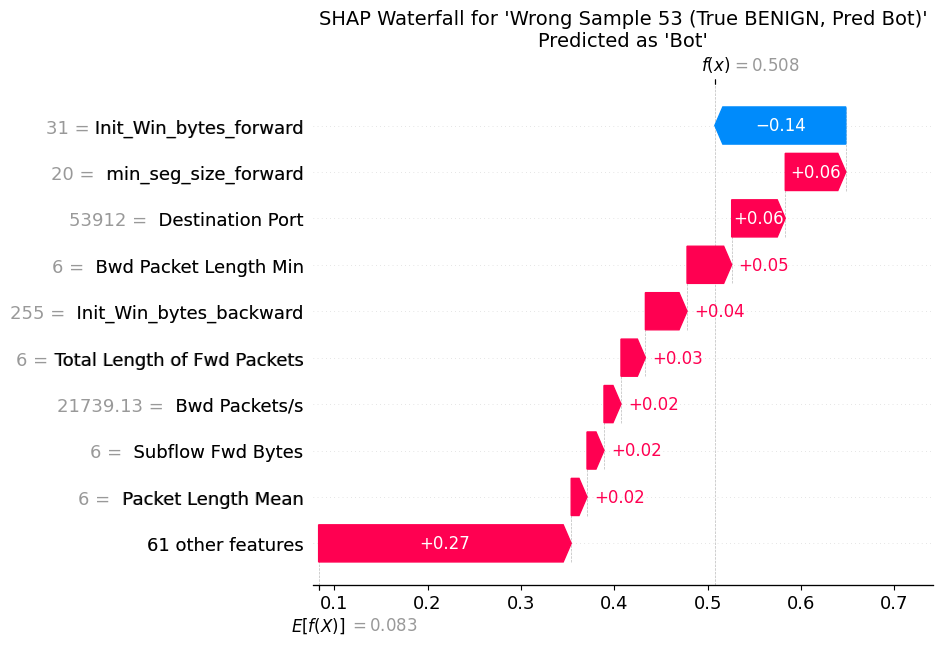


[SHAP] 正在生成 Force Plot (交互式)...



[LIME] 正在生成解释...
[LIME] 将为类别 ['BENIGN', 'Bot'] 生成解释。

[LIME] 可读性增强版文本摘要:



### 所有分析已完成！ ###


In [ ]:
shap.initjs()

# 3.2: 实例化新的TreeXAIAnalyzer
# 注意：我们不再传入scaler，因为我们没有使用它
tree_analyzer = TreeXAIAnalyzer(
    model=rf_clf,
    X_train=X_train,
    class_names=le.classes_.tolist(),
    feature_names=features
    # scaler=None 是默认值，无需填写
)
print("树模型XAI分析器已准备就绪。")

# 3.3: 进行调用
# (A) 分析全局特征重要性
tree_analyzer.generate_shap_summary_plot(X_test, max_samples=200, save_plots_path="xai_reports_tree")

# (B) 分析错误预测的样本
tree_analyzer.analyze_wrong_predictions(X_test, y_test, max_samples=3, save_plots_path="xai_reports_tree")

print("\n### 所有分析已完成！ ###")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,124 (70.80 KB)

 Trainable params: 18,124 (70.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9203 - loss: 0.2933 - val_accuracy: 0.9717 - val_loss: 0.0664
Epoch 2/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9697 - loss: 0.0756 - val_accuracy: 0.9766 - val_loss: 0.0554
Epoch 3/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9740 - loss: 0.0619 - val_accuracy: 0.9773 - val_loss: 0.0488
Epoch 4/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9768 - loss: 0.0558 - val_accuracy: 0.9828 - val_loss: 0.0442
Epoch 5/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9787 - loss: 0.0517 - val_accuracy: 0.9845 - val_loss: 0.0412
Epoch 6/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9799 - loss: 0.0491 - val_accuracy: 0.9842 - val_loss: 0.0401
Epoch 7/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9805 - loss: 0.0475 - val_accuracy: 0.9839 - val_loss: 0.0399
Epoch 8/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9813 - loss: 

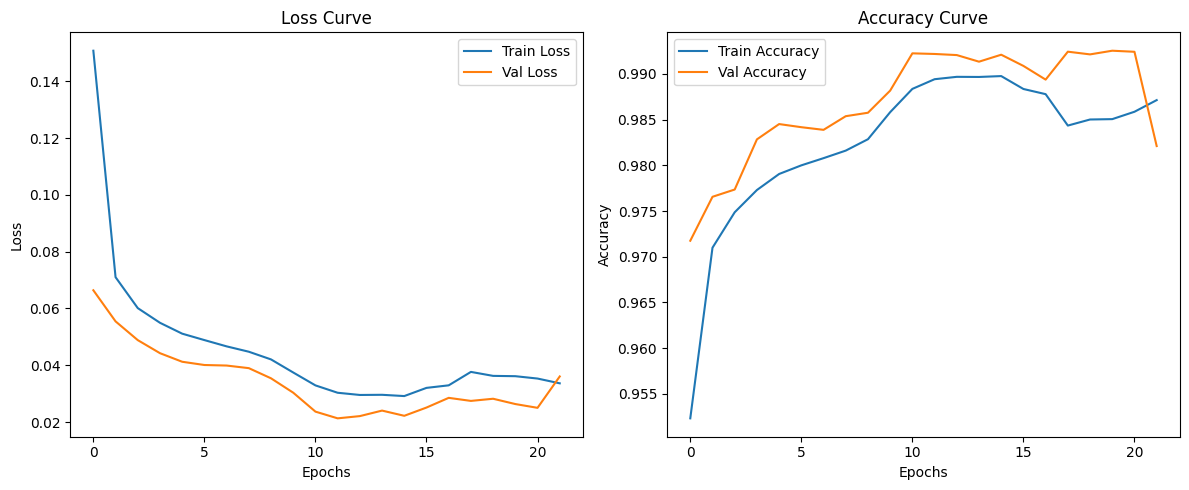

17684/17684 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
Test Accuracy: 0.9921

Classification Report:
                  precision    recall  f1-score   support

          BENIGN       0.99      1.00      1.00    454538
             Bot       0.96      0.34      0.50       393
            DDoS       1.00      1.00      1.00     25605
   DoS GoldenEye       0.99      0.97      0.98      2059
        DoS Hulk       1.00      0.94      0.97     46025
DoS Slowhttptest       0.86      0.98      0.92      1100
   DoS slowloris       0.98      0.93      0.96      1159
     FTP-Patator       0.98      0.99      0.98      1588
    Infiltration       0.00      0.00      0.00         7
        PortScan       0.99      1.00      0.99     31786
     SSH-Patator       0.96      0.97      0.97      1179
      Web Attack       0.92      0.05      0.10       438

        accuracy                           0.99    565877
       macro avg       0.89      0.76      0.78    565877
    weighted avg       0.99      0.9

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


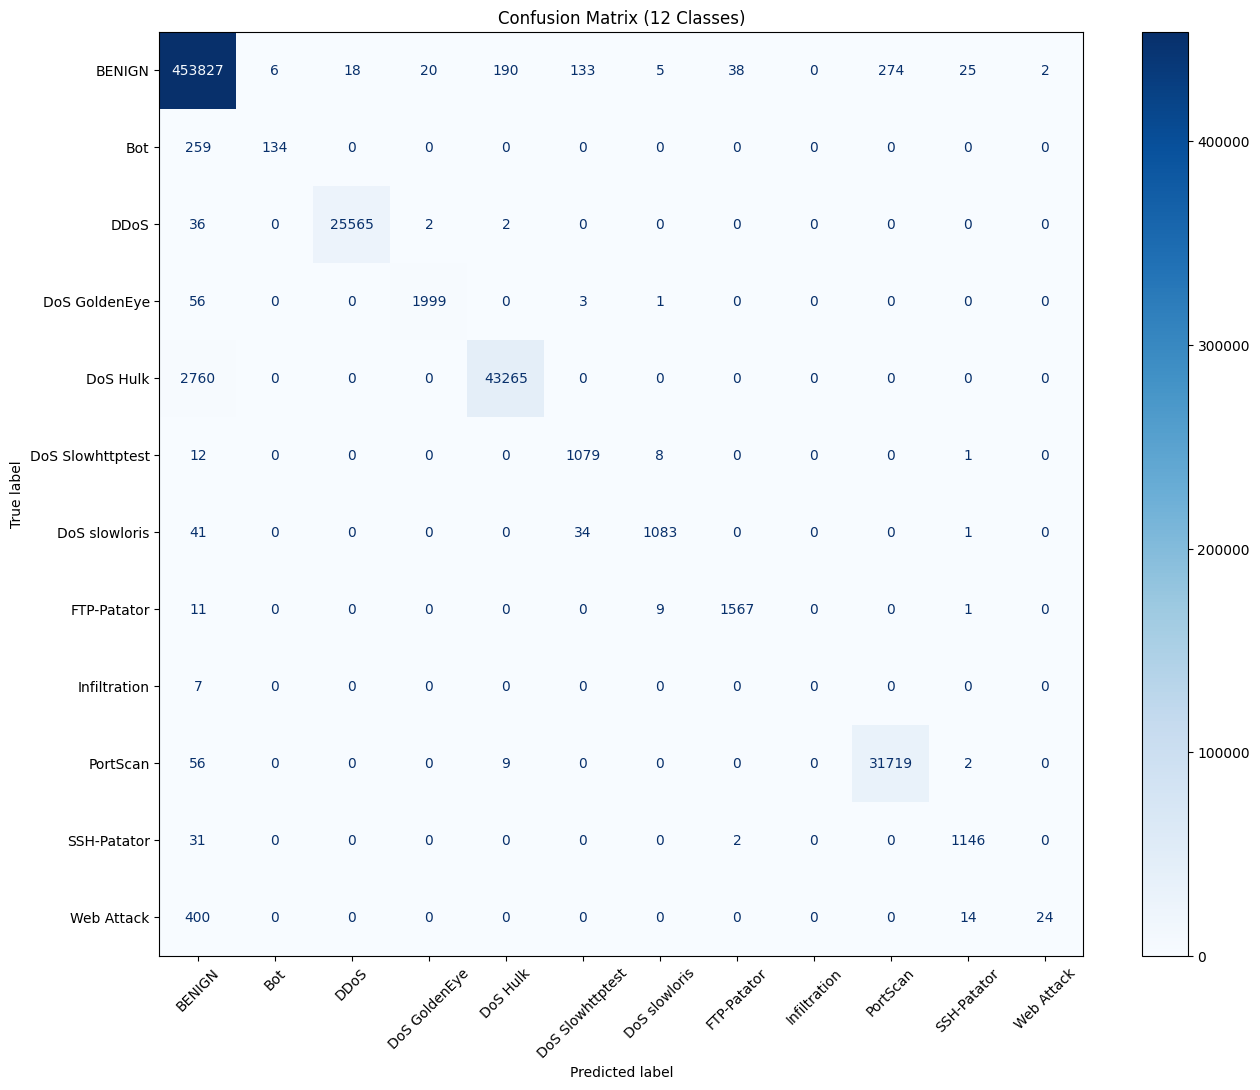

In [ ]:
#MLP

# divide data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

num_classes = len(le.classes_)
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_val_onehot = to_categorical(y_val, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

# standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

def build_mlp_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


input_shape = X_train_scaled.shape[1]
mlp = build_mlp_model(input_shape, num_classes)
mlp.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# train model
history = mlp.fit(
    X_train_scaled, y_train_onehot,
    validation_data=(X_val_scaled, y_val_onehot),
    epochs=200,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=1
)

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# prediction
y_pred_proba = mlp.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

#evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

class_names = le.classes_.tolist()
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

fig, ax = plt.subplots(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (12 Classes)")
plt.show()

In [ ]:
import shap
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Any, Dict, Optional, Union
import os
from IPython.display import display, HTML

# 忽略一些shap和matplotlib的警告
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

class XAIAnalyzer:
    """
    针对深度学习模型的XAI分析器【最终修正版 v2】。
    - 核心功能: 解决了因数据标准化导致图表可读性差的问题。
    - 增强SHAP: 图表中将显示原始、未标准化的特征值。
    - 增强LIME: 除了显示原始图表，还会额外生成一份可读性强的文本摘要。
    - [修正]: 修复了 GradientExplainer 没有 expected_value 属性的bug。
    """
    def __init__(self,
                 model: Any,
                 X_train_scaled: pd.DataFrame,
                 class_names: List[str],
                 X_train_unscaled: Optional[pd.DataFrame] = None,
                 use_gradient_explainer: bool = True):
        self.model = model
        self.X_train_scaled = X_train_scaled
        self.X_train_unscaled = X_train_unscaled if X_train_unscaled is not None else X_train_scaled
        self.class_names = class_names
        self.feature_names = X_train_scaled.columns.tolist()
        self.use_gradient_explainer = use_gradient_explainer

        self.shap_explainer = None
        self.lime_explainer = None
        self.shap_expected_value = None

    def _create_shap_explainer(self, background_samples: int = 100):
        """(内部方法) 创建并缓存SHAP解释器。"""
        if self.shap_explainer is None:
            print(f"正在创建SHAP {'GradientExplainer' if self.use_gradient_explainer else 'DeepExplainer'}...")
            background_data = shap.sample(self.X_train_scaled, min(background_samples, len(self.X_train_scaled)))

            # --- [核心修正] ---
            # 恢复手动计算期望值。这是最可靠的方法，特别是对于 GradientExplainer。
            print("正在手动计算模型的期望值 (expected value)...")
            self.shap_expected_value = self.model.predict(background_data).mean(axis=0)
            print(f"计算完成。模型期望值 (各类别平均概率): {self.shap_expected_value}")
            # --- [修正结束] ---

            if self.use_gradient_explainer:
                self.shap_explainer = shap.GradientExplainer(self.model, background_data)
            else:
                self.shap_explainer = shap.DeepExplainer(self.model, background_data)

        return self.shap_explainer

    def _create_lime_explainer(self):
        """(内部方法) 创建并缓存LIME解释器。"""
        if self.lime_explainer is None:
            print("正在创建LIME TabularExplainer...")
            self.lime_explainer = lime.lime_tabular.LimeTabularExplainer(
                training_data=self.X_train_scaled.values,
                feature_names=self.feature_names,
                class_names=self.class_names,
                mode='classification'
            )
        return self.lime_explainer

    def explain_single_instance(self,
                                instance_scaled: pd.Series,
                                instance_unscaled: pd.Series,
                                instance_name: str = "Sample",
                                specific_lime_labels: Optional[List[int]] = None,
                                lime_num_features: int = 10,
                                save_plots_path: Optional[str] = None):
        print("\n" + "="*25 + f" 分析样本: {instance_name} " + "="*25)

        instance_scaled_df = pd.DataFrame([instance_scaled])
        instance_scaled_values = instance_scaled_df.values
        instance_unscaled_df = pd.DataFrame([instance_unscaled])

        pred_proba = self.model.predict(instance_scaled_values)
        pred_class_index = np.argmax(pred_proba)
        pred_class_name = self.class_names[pred_class_index]
        print(f"模型预测结果: '{pred_class_name}' (概率: {pred_proba[0][pred_class_index]:.4f})")

        explainer = self._create_shap_explainer()
        shap_explanations = explainer(instance_scaled_values)

        print("\n[SHAP] 正在生成 Waterfall Plot...")
        shap_values_for_class = shap_explanations.values[0, :, pred_class_index]
        base_value_for_class = self.shap_expected_value[pred_class_index]

        explanation_for_waterfall = shap.Explanation(
            values=shap_values_for_class,
            base_values=base_value_for_class,
            data=instance_unscaled.values,
            feature_names=self.feature_names
        )
        shap.waterfall_plot(explanation_for_waterfall, show=False)
        plt.title(f"SHAP Waterfall for '{instance_name}'\nPredicted as '{pred_class_name}'", fontsize=14)
        if save_plots_path:
            self._save_plot(save_plots_path, f"{instance_name}_SHAP_Waterfall.png")
        plt.show(); plt.close()

        print("\n[SHAP] 正在生成 Force Plot (交互式)...")
        force_plot = shap.force_plot(
            base_value=base_value_for_class,
            shap_values=shap_values_for_class,
            features=instance_unscaled_df
        )
        display(force_plot)

        print("\n[LIME] 正在生成解释...")
        lime_explainer = self._create_lime_explainer()

        lime_labels_to_explain = specific_lime_labels if specific_lime_labels is not None else [pred_class_index]
        print(f"[LIME] 将为类别 {[self.class_names[i] for i in lime_labels_to_explain]} 生成解释。")

        lime_exp = lime_explainer.explain_instance(
            instance_scaled.values,
            self.model.predict,
            num_features=lime_num_features,
            labels=lime_labels_to_explain
        )

        print("[LIME] 正在生成 LIME Plot (基于标准化数据)...")
        lime_exp.show_in_notebook(show_table=True, labels=lime_labels_to_explain)

        print("\n[LIME] 可读性增强版文本摘要:")
        html_output = "<div>"
        for label_index in lime_labels_to_explain:
            html_output += f"<h4>对 '{self.class_names[label_index]}' 预测的解释:</h4>"
            html_output += "<ul>"
            explanation_list = lime_exp.as_list(label=label_index)
            for feature_desc, weight in explanation_list:
                feature_name = next((f for f in self.feature_names if f in feature_desc), None)
                if not feature_name: continue

                original_value = instance_unscaled[feature_name]
                impact_color = "green" if weight > 0 else "red"
                impact_text = "正面" if weight > 0 else "负面"

                html_output += (f"<li><b>{feature_name} = {original_value:.2f}</b> "
                                f"对此预测有 <b style='color:{impact_color};'>{impact_text}</b> 影响 "
                                f"(权重: {weight:.4f})</li>")
            html_output += "</ul>"
        html_output += "</div>"
        display(HTML(html_output))

    # analyze_wrong_predictions, generate_shap_summary_plot, find_predictions, _save_plot
    # 这些方法的代码保持不变，为简洁起见此处省略，您无需修改它们。
    # 如果您需要，我可以将它们也一并附上。
    def analyze_wrong_predictions(self,
                                  X_test_scaled: pd.DataFrame,
                                  y_test: Union[pd.Series, np.ndarray],
                                  X_test_unscaled: Optional[pd.DataFrame] = None,
                                  max_samples: int = 3,
                                  save_plots_path: Optional[str] = None):
        if X_test_unscaled is None:
            print("警告: 未提供未标准化的X_test_unscaled，图表可读性会较差。")
            X_test_unscaled = X_test_scaled

        y_test_series = pd.Series(y_test)
        prediction_results = self.find_predictions(X_test_scaled, y_test_series)
        wrong_indices = prediction_results["wrong_indices"]

        if not wrong_indices.any():
            print("\n🎉 模型没有错误预测！无需分析。")
            return

        print(f"\n--- 将对前 {min(max_samples, len(wrong_indices))} 个错误预测样本进行深度分析 ---")

        for i, idx in enumerate(wrong_indices[:max_samples]):
            instance_scaled = X_test_scaled.iloc[idx]
            instance_unscaled = X_test_unscaled.iloc[idx]

            true_label_index = int(y_test_series.iloc[idx])
            true_label_name = self.class_names[true_label_index]
            pred_label_index = prediction_results["y_pred_labels"][idx]
            pred_label_name = self.class_names[pred_label_index]

            instance_name = f"Wrong Sample {idx} (True {true_label_name}, Pred {pred_label_name})"
            labels_for_lime = sorted(list(set([true_label_index, pred_label_index])))

            self.explain_single_instance(instance_scaled, instance_unscaled, instance_name,
                                         specific_lime_labels=labels_for_lime,
                                         save_plots_path=save_plots_path)

    def generate_shap_summary_plot(self,
                                   X_to_explain_scaled: pd.DataFrame,
                                   X_to_explain_unscaled: Optional[pd.DataFrame] = None,
                                   max_samples: int = 200,
                                   save_plots_path: Optional[str] = None):
        print("\n--- 正在生成SHAP Summary Plots ---")

        if X_to_explain_unscaled is None:
            print("警告: 未提供未标准化的数据，摘要图可读性会较差。")
            X_to_explain_unscaled = X_to_explain_scaled

        explainer = self._create_shap_explainer()

        sample_scaled = X_to_explain_scaled.iloc[:min(max_samples, len(X_to_explain_scaled))]
        sample_unscaled = X_to_explain_unscaled.iloc[:min(max_samples, len(X_to_explain_unscaled))]

        print(f"正在为 {len(sample_scaled)} 个样本计算SHAP值 (这可能需要一些时间)...")
        shap_values = explainer.shap_values(sample_scaled.values)

        print("\n[SHAP] 正在生成 Beeswarm Plot...")
        shap.summary_plot(shap_values, sample_unscaled, plot_type="dot", class_names=self.class_names, show=False)
        if save_plots_path:
            self._save_plot(save_plots_path, "SHAP_Summary_Beeswarm.png")
        plt.show(); plt.close()

        print("\n[SHAP] 正在生成 Bar Plot...")
        shap.summary_plot(shap_values, sample_unscaled, plot_type="bar", class_names=self.class_names, show=False)
        if save_plots_path:
            self._save_plot(save_plots_path, "SHAP_Summary_Bar.png")
        plt.show(); plt.close()

    def find_predictions(self, X_test: pd.DataFrame, y_test: pd.Series) -> Dict[str, Any]:
        print("\n--- 正在分析模型预测结果 ---")
        y_pred_proba = self.model.predict(X_test)
        y_pred_labels = np.argmax(y_pred_proba, axis=1)
        wrong_indices = np.where(y_pred_labels != y_test.values)[0]
        correct_indices = np.where(y_pred_labels == y_test.values)[0]

        print(f"总样本数: {len(y_test)}")
        print(f"✅ 正确预测数: {len(correct_indices)}")
        print(f"❌ 错误预测数: {len(wrong_indices)}")
        if len(y_test) > 0:
            print(f"准确率: {len(correct_indices) / len(y_test):.2%}")
        return {"y_pred_proba": y_pred_proba, "y_pred_labels": y_pred_labels, "wrong_indices": wrong_indices, "correct_indices": correct_indices}

    def _save_plot(self, path: str, filename: str):
        os.makedirs(path, exist_ok=True)
        safe_filename = "".join(c for c in filename if c.isalnum() or c in (' ', '_', '.', '-')).rstrip()
        full_path = os.path.join(path, safe_filename)
        plt.savefig(full_path, bbox_inches='tight')
        print(f"图表已保存至: {full_path}")

In [ ]:
# 假设您有以下数据：
# model: 训练好的模型
# X_train_scaled, X_train_unscaled: 训练集 (标准化和原始)
# X_test_scaled, X_test_unscaled: 测试集 (标准化和原始)
# y_train, y_test: 标签
# class_names: ['类别A', '类别B']
save_path = "./xai_plots"
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=features)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=features)
shap.initjs()
# --- 1. 初始化分析器 ---
# 传入标准化和原始的训练数据
analyzer = XAIAnalyzer(
    model=mlp,
    X_train_scaled=X_train_scaled,
    class_names=le.classes_.tolist(),
    X_train_unscaled=X_train, # <--- 传入原始数据
    use_gradient_explainer=True
)

# --- 2. 分析单个正确样本 ---
# 假设我们想分析测试集中的第5个样本
# instance_idx = 5
# instance_s = X_test_scaled.iloc[instance_idx]
# instance_u = X_test.iloc[instance_idx]
# analyzer.explain_single_instance(
#     instance_scaled=instance_s,
#     instance_unscaled=instance_u, # <--- 传入原始样本
#     instance_name=f"Sample_{instance_idx}",
#     save_plots_path=save_path
# )

# --- 3. 分析错误预测 ---
# 传入标准化和原始的测试数据
analyzer.analyze_wrong_predictions(
    X_test_scaled=X_test_scaled,
    y_test=y_test,
    X_test_unscaled=X_test, # <--- 传入原始数据
    max_samples=3,
    save_plots_path=save_path
)

# --- 4. 生成全局摘要图 ---
# 传入标准化和原始的数据集用于解释
analyzer.generate_shap_summary_plot(
    X_to_explain_scaled=X_test_scaled,
    X_to_explain_unscaled=X_test, # <--- 传入原始数据
    max_samples=1000, # 可以根据需要调整样本量
    save_plots_path=save_path
)

Output hidden; open in https://colab.research.google.com to view.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 256)            │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,900 (241.80 KB)

 Trainable params: 61,004 (238.30 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9088 - loss: 0.3620 - val_accuracy: 0.9705 - val_loss: 0.0765 - learning_rate: 0.0010
Epoch 2/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9703 - loss: 0.0727 - val_accuracy: 0.9788 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 3/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9801 - loss: 0.0511 - val_accuracy: 0.9871 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 4/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9855 - loss: 0.0388 - val_accuracy: 0.9917 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 5/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9857 - loss: 0.0377 - val_accuracy: 0.9904 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 6/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9859 - loss: 0.0365 - val_accuracy: 0.9777 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 7/200
1769/1769 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.

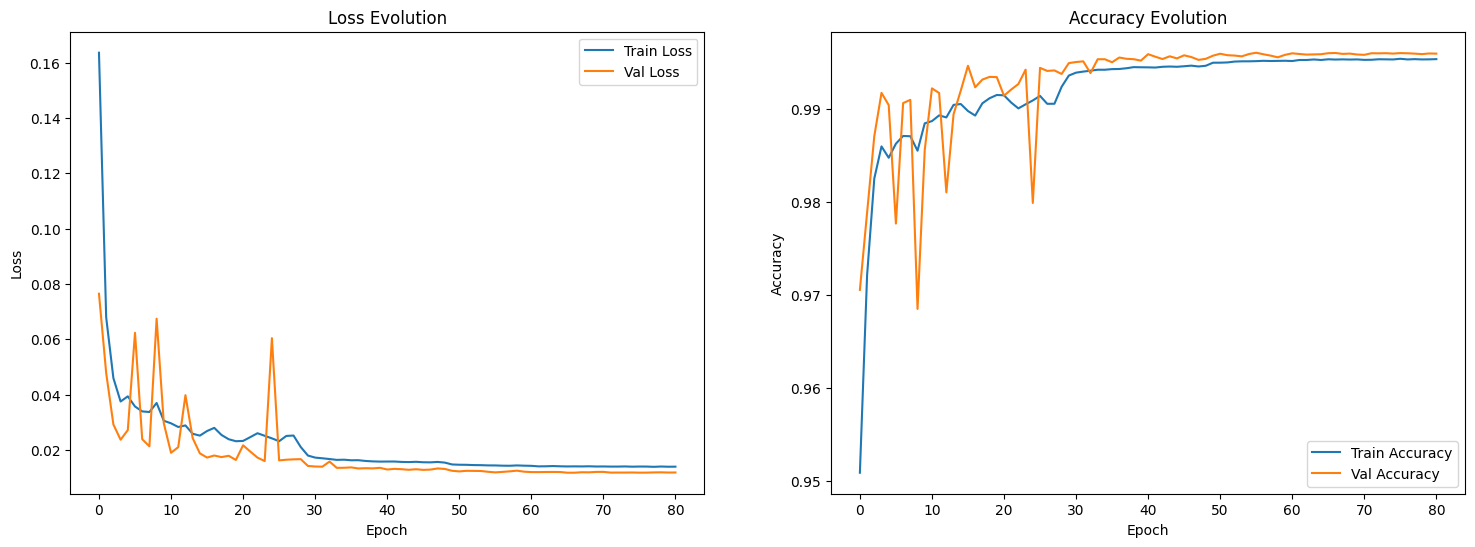

17684/17684 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step

Classification Report:
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    454538
             Bot       0.98      0.35      0.51       393
            DDoS       1.00      1.00      1.00     25605
   DoS GoldenEye       0.99      0.99      0.99      2059
        DoS Hulk       0.98      0.99      0.99     46025
DoS Slowhttptest       0.89      0.99      0.93      1100
   DoS slowloris       0.99      0.99      0.99      1159
     FTP-Patator       1.00      0.99      1.00      1588
    Infiltration       1.00      0.14      0.25         7
        PortScan       0.99      1.00      1.00     31786
     SSH-Patator       0.95      0.98      0.97      1179
      Web Attack       0.94      0.07      0.13       438

        accuracy                           1.00    565877
       macro avg       0.98      0.79      0.81    565877
    weighted avg       1.00      1.00      1.00    565877


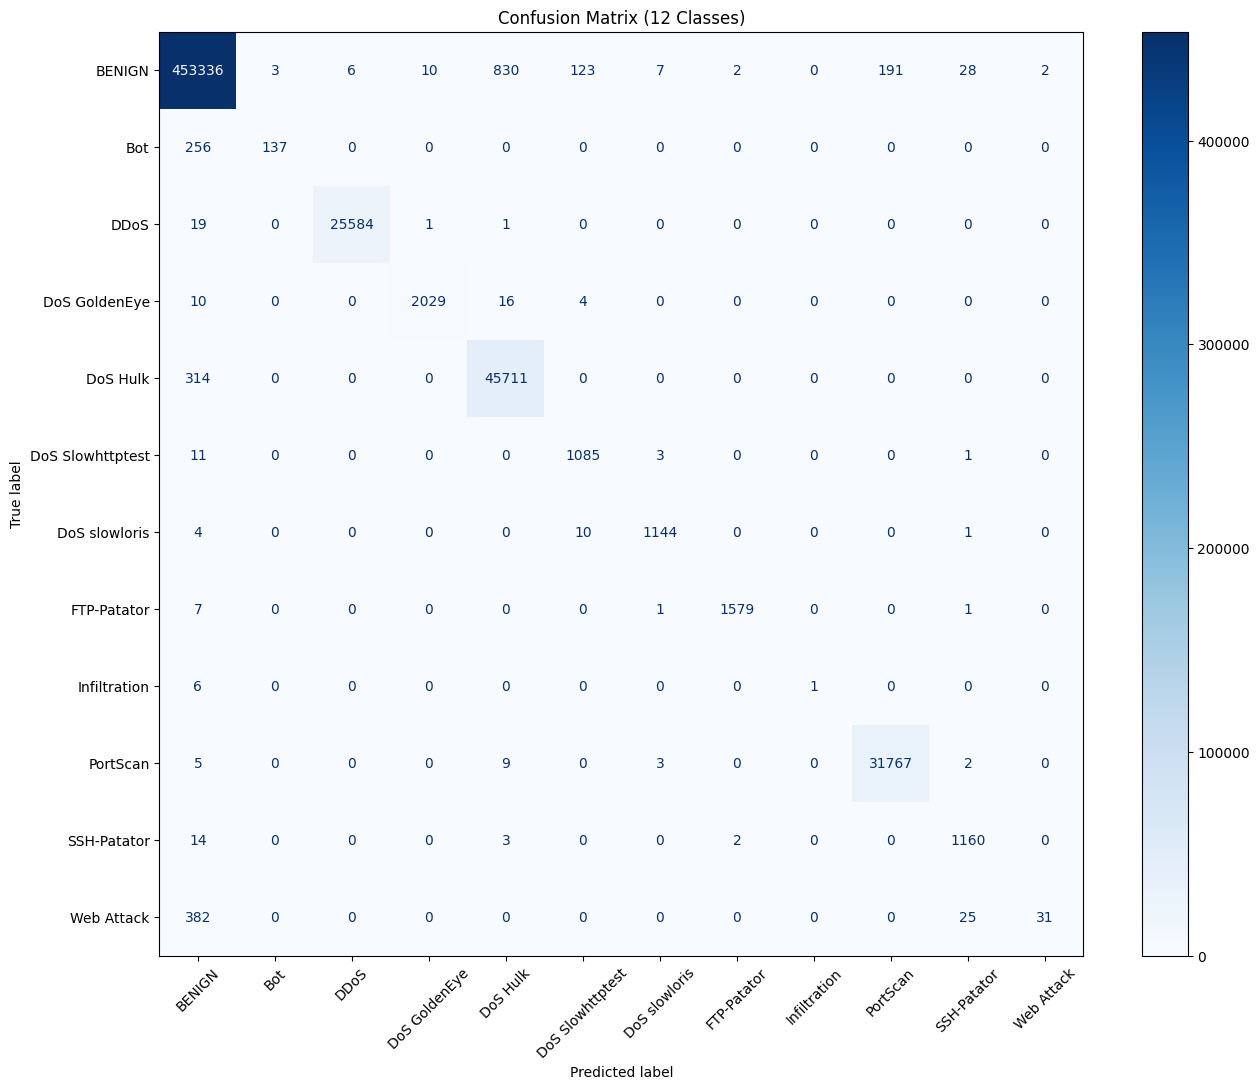


Top 10 Frequent Errors:
True_Class     Predicted_Class 
BENIGN         DoS Hulk            830
Web Attack     BENIGN              382
DoS Hulk       BENIGN              314
Bot            BENIGN              256
BENIGN         PortScan            191
               DoS Slowhttptest    123
               SSH-Patator          28
Web Attack     SSH-Patator          25
DDoS           BENIGN               19
DoS GoldenEye  DoS Hulk             16
Name: count, dtype: int64


In [ ]:
#DNN

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# encode
num_classes = len(le.classes_)
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_val_onehot = to_categorical(y_val, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

def build_dnn_model(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        weight_decay=1e-4
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

input_shape = X_train_scaled.shape[1]
dnn = build_dnn_model(input_shape, num_classes)
dnn.summary()

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
]

# train model
history = dnn.fit(
    X_train_scaled, y_train_onehot,
    validation_data=(X_val_scaled, y_val_onehot),
    epochs=200,
    batch_size=1024,
    callbacks=callbacks,
    verbose=1
)

# plot
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Evolution')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax2.set_title('Accuracy Evolution')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

plot_history(history)

# prediction
y_pred_proba = dnn.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

# evaluation
class_names = le.classes_.tolist()
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

fig, ax = plt.subplots(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (12 Classes)")
plt.show()

# analysis
error_mask = y_pred != y_test
error_samples = X_test[error_mask]
error_true = y_test[error_mask]
error_pred = y_pred[error_mask]

error_df = pd.DataFrame({
    'True_Class': le.inverse_transform(error_true),
    'Predicted_Class': le.inverse_transform(error_pred)
})
print("\nTop 10 Frequent Errors:")
print(error_df.value_counts().head(10))

In [ ]:
# 假设您有以下数据：
# model: 训练好的模型
# X_train_scaled, X_train_unscaled: 训练集 (标准化和原始)
# X_test_scaled, X_test_unscaled: 测试集 (标准化和原始)
# y_train, y_test: 标签
# class_names: ['类别A', '类别B']
save_path = "./xai_plots"
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=features)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=features)
shap.initjs()
# --- 1. 初始化分析器 ---
# 传入标准化和原始的训练数据
analyzer = XAIAnalyzer(
    model=dnn,
    X_train_scaled=X_train_scaled,
    class_names=le.classes_.tolist(),
    X_train_unscaled=X_train, # <--- 传入原始数据
    use_gradient_explainer=True
)

# --- 2. 分析单个正确样本 ---
# 假设我们想分析测试集中的第5个样本
# instance_idx = 5
# instance_s = X_test_scaled.iloc[instance_idx]
# instance_u = X_test.iloc[instance_idx]
# analyzer.explain_single_instance(
#     instance_scaled=instance_s,
#     instance_unscaled=instance_u, # <--- 传入原始样本
#     instance_name=f"Sample_{instance_idx}",
#     save_plots_path=save_path
# )

# --- 3. 分析错误预测 ---
# 传入标准化和原始的测试数据
analyzer.analyze_wrong_predictions(
    X_test_scaled=X_test_scaled,
    y_test=y_test,
    X_test_unscaled=X_test, # <--- 传入原始数据
    max_samples=3,
    save_plots_path=save_path
)

# --- 4. 生成全局摘要图 ---
# 传入标准化和原始的数据集用于解释
analyzer.generate_shap_summary_plot(
    X_to_explain_scaled=X_test_scaled,
    X_to_explain_unscaled=X_test, # <--- 传入原始数据
    max_samples=1000, # 可以根据需要调整样本量
    save_plots_path=save_path
)

Output hidden; open in https://colab.research.google.com to view.

[0]	validation_0-mlogloss:1.91854	validation_1-mlogloss:1.91851
[1]	validation_0-mlogloss:1.60090	validation_1-mlogloss:1.60088
[2]	validation_0-mlogloss:1.37420	validation_1-mlogloss:1.37416
[3]	validation_0-mlogloss:1.19785	validation_1-mlogloss:1.19783
[4]	validation_0-mlogloss:1.05548	validation_1-mlogloss:1.05546
[5]	validation_0-mlogloss:0.93634	validation_1-mlogloss:0.93633
[6]	validation_0-mlogloss:0.83475	validation_1-mlogloss:0.83474
[7]	validation_0-mlogloss:0.74666	validation_1-mlogloss:0.74664
[8]	validation_0-mlogloss:0.67019	validation_1-mlogloss:0.67017
[9]	validation_0-mlogloss:0.60313	validation_1-mlogloss:0.60310
[10]	validation_0-mlogloss:0.54382	validation_1-mlogloss:0.54379
[11]	validation_0-mlogloss:0.49092	validation_1-mlogloss:0.49089
[12]	validation_0-mlogloss:0.44368	validation_1-mlogloss:0.44364
[13]	validation_0-mlogloss:0.40166	validation_1-mlogloss:0.40163
[14]	validation_0-mlogloss:0.36382	validation_1-mlogloss:0.36378
[15]	validation_0-mlogloss:0.32986	

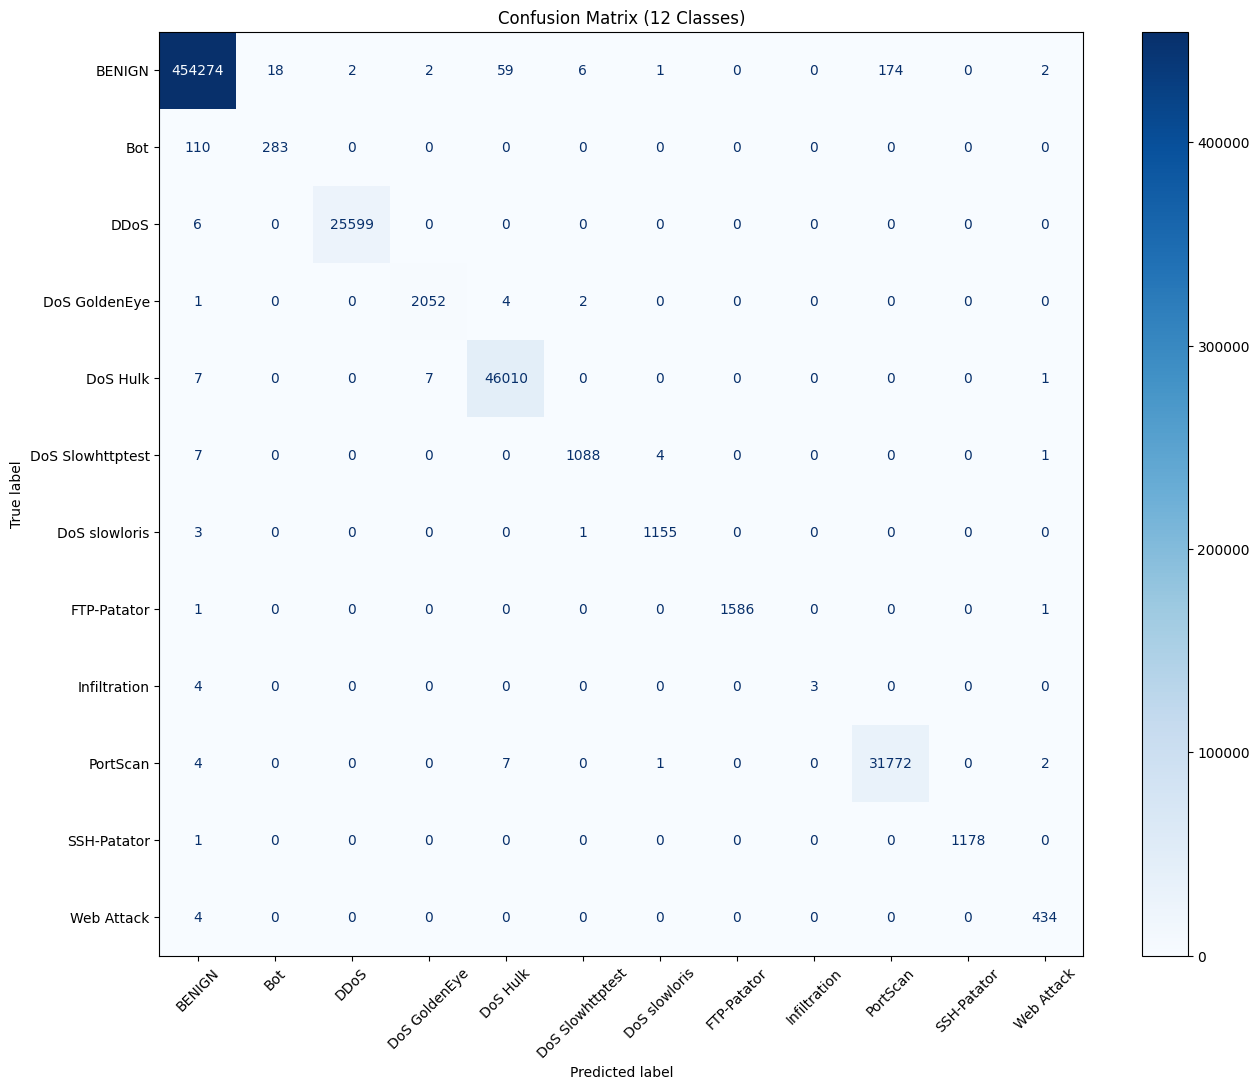

<Figure size 1200x800 with 0 Axes>

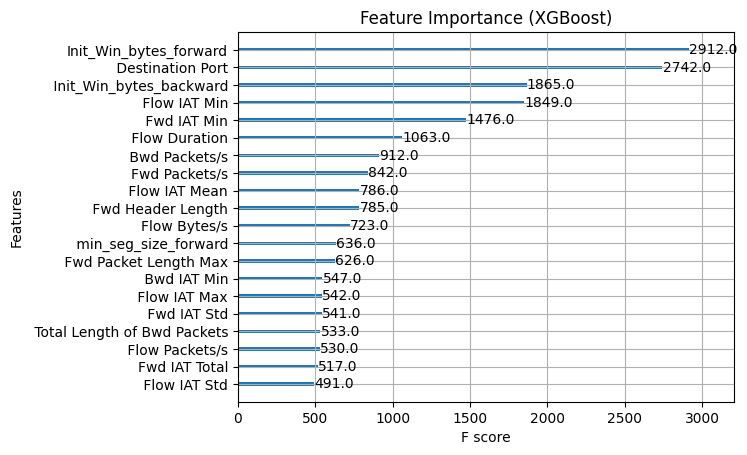

In [ ]:
#XGBoost
from xgboost import XGBClassifier, plot_importance, plot_tree

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    learning_rate=0.1,
    n_estimators=200,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=20,
    scale_pos_weight=None
)

# train model
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

# prediction
y_pred = xgb_clf.predict(X_test)

# evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

class_names = le.classes_.tolist()
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

fig, ax = plt.subplots(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (12 Classes)")
plt.show()

# feature importance
plt.figure(figsize=(12, 8))
plot_importance(xgb_clf, max_num_features=20)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [ ]:
import shap
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Any, Dict, Optional, Union
import os
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

class TreeXAIAnalyzer:
    """
    针对树模型（如RandomForest, XGBoost）优化的XAI分析器【DimensionError修正版】。
    - 使用高效的 shap.TreeExplainer。
    - 数据标准化(scaler)变为可选。
    - [修正]: 采用现代SHAP API调用方式，解决DimensionError。
    """
    def __init__(self, model: Any, X_train: pd.DataFrame, class_names: List[str], feature_names: List[str], scaler: Optional[StandardScaler] = None):
        self.model = model
        self.X_train = X_train
        self.class_names = class_names
        self.feature_names = feature_names
        self.scaler = scaler
        self.shap_explainer = None
        self.lime_explainer = None
        self.shap_expected_value = None

    def _create_shap_explainer(self):
        if self.shap_explainer is None:
            print("正在创建SHAP TreeExplainer...")
            self.shap_explainer = shap.TreeExplainer(self.model)
            self.shap_expected_value = self.shap_explainer.expected_value
            if isinstance(self.shap_expected_value, list) and len(self.shap_expected_value) > 1:
                 print(f"计算完成。多分类期望值 (Base Rate for Predictions): 已捕获")
            else:
                 print(f"计算完成。模型期望值: {self.shap_expected_value}")
        return self.shap_explainer

    def _create_lime_explainer(self):
        if self.lime_explainer is None:
            print("正在创建LIME TabularExplainer...")
            self.lime_explainer = lime.lime_tabular.LimeTabularExplainer(
                training_data=self.X_train.values,
                feature_names=self.feature_names,
                class_names=self.class_names,
                mode='classification'
            )
        return self.lime_explainer

    def explain_single_instance(self,
                                instance_to_explain: pd.Series,
                                instance_name: str = "Sample",
                                specific_lime_labels: Optional[List[int]] = None,
                                lime_num_features: int = 10,
                                save_plots_path: Optional[str] = None):

        print("\n" + "="*25 + f" 分析样本: {instance_name} " + "="*25)

        instance_df = pd.DataFrame([instance_to_explain])

        if self.scaler:
            instance_unscaled_df = pd.DataFrame(
                self.scaler.inverse_transform(instance_df),
                columns=self.feature_names
            )
        else:
            instance_unscaled_df = instance_df

        pred_proba = self.model.predict_proba(instance_df)
        pred_class_index = np.argmax(pred_proba)
        pred_class_name = self.class_names[pred_class_index]
        print(f"模型预测结果: '{pred_class_name}' (概率: {pred_proba[0][pred_class_index]:.4f})")

        explainer = self._create_shap_explainer()

        # 【核心修正】: 不再使用 .shap_values()，而是直接调用 explainer() 获得完整的 Explanation 对象
        shap_explanations = explainer(instance_df)

        # 从 Explanation 对象中安全地提取所需信息
        # shap_explanations[0, :, pred_class_index] 会得到一个只包含单个类别信息的、干净的Explanation切片
        explanation_for_class = shap_explanations[0, :, pred_class_index]
        shap_values_for_class = explanation_for_class.values
        base_value_for_class = explanation_for_class.base_values

        # --- SHAP Waterfall Plot ---
        print("\n[SHAP] 正在生成 Waterfall Plot...")
        # 为了确保显示原始数据，我们需要用未标准化的数据创建一个新的Explanation对象用于绘图
        explanation_for_waterfall = shap.Explanation(
            values=shap_values_for_class,
            base_values=base_value_for_class,
            data=instance_unscaled_df.iloc[0].values,
            feature_names=self.feature_names
        )
        shap.waterfall_plot(explanation_for_waterfall, show=False)
        plt.title(f"SHAP Waterfall for '{instance_name}'\nPredicted as '{pred_class_name}'", fontsize=14)
        if save_plots_path: self._save_plot(save_plots_path, f"{instance_name}_SHAP_Waterfall.png")
        plt.show(); plt.close()

        # --- SHAP Force Plot ---
        print("\n[SHAP] 正在生成 Force Plot (交互式)...")
        # 【核心修正】: 为force_plot的features参数传递一个1D Series或array，而不是整个DataFrame
        force_plot = shap.force_plot(
            base_value=base_value_for_class,
            shap_values=shap_values_for_class,
            features=instance_unscaled_df.iloc[0] # 使用 .iloc[0] 来获取Series
        )
        display(force_plot)

        # --- LIME 分析 (保持不变) ---
        print("\n[LIME] 正在生成解释...")
        lime_explainer = self._create_lime_explainer()
        lime_labels_to_explain = specific_lime_labels if specific_lime_labels is not None else [pred_class_index]
        print(f"[LIME] 将为类别 {[self.class_names[i] for i in lime_labels_to_explain]} 生成解释。")
        lime_exp = lime_explainer.explain_instance(
            instance_to_explain.values, self.model.predict_proba,
            num_features=lime_num_features, labels=lime_labels_to_explain
        )

        print("[LIME] 正在生成 LIME Plot (基于标准化数据)...")
        lime_exp.show_in_notebook(show_table=True, labels=lime_labels_to_explain)

        print("\n[LIME] 可读性增强版文本摘要:")
        html_output = "<div>"
        for label_index in lime_labels_to_explain:
             html_output += f"<h4>对 '{self.class_names[label_index]}' 预测的解释:</h4><ul>"
             explanation_list = lime_exp.as_list(label=label_index)
             for feature_desc, weight in explanation_list:
                 feature_name = next((f for f in self.feature_names if f in feature_desc), None)
                 if not feature_name: continue
                 original_value = instance_unscaled_df.iloc[0][feature_name]
                 impact_color, impact_text = ("green", "正面") if weight > 0 else ("red", "负面")
                 html_output += (f"<li><b>{feature_name} = {original_value:.2f}</b> "
                                 f"对此预测有 <b style='color:{impact_color};'>{impact_text}</b> 影响 "
                                 f"(权重: {weight:.4f})</li>")
             html_output += "</ul>"
        html_output += "</div>"
        display(HTML(html_output))

    # 其他方法无需修改，为方便您直接复制使用，此处一并提供
    def analyze_wrong_predictions(self, X_test: pd.DataFrame, y_test: Union[pd.Series, np.ndarray], max_samples: int = 3, save_plots_path: Optional[str] = None):
        # 决定未标准化的数据源
        if self.scaler:
            # 如果有scaler，只能假设X_test是标准化的，并且无法直接获得未标准化的版本
            # 这是一个设计上的权衡，或者需要在调用时同时传入 X_test_scaled 和 X_test_unscaled
            # 为了简化，我们只在 explain_single_instance 内部处理
            pass

        y_test_series = pd.Series(y_test) if isinstance(y_test, np.ndarray) else y_test
        prediction_results = self.find_predictions(X_test, y_test_series)
        wrong_indices = prediction_results["wrong_indices"]

        if not wrong_indices.any():
            print("\n🎉 模型没有错误预测！无需分析。")
            return

        print(f"\n--- 将对前 {min(max_samples, len(wrong_indices))} 个错误预测样本进行深度分析 ---")

        for i, idx in enumerate(wrong_indices[:max_samples]):
            instance = X_test.iloc[idx]

            true_label_index = int(y_test_series.iloc[idx])
            true_label_name = self.class_names[true_label_index]
            pred_label_index = prediction_results["y_pred_labels"][idx]
            pred_label_name = self.class_names[pred_label_index]

            instance_name = f"Wrong Sample {idx} (True {true_label_name}, Pred {pred_label_name})"
            labels_for_lime = sorted(list(set([true_label_index, pred_label_index])))

            self.explain_single_instance(instance, instance_name,
                                         specific_lime_labels=labels_for_lime,
                                         save_plots_path=save_plots_path)

    def generate_shap_summary_plot(self, X_to_explain: pd.DataFrame, max_samples: int = 200, save_plots_path: Optional[str] = None):
        print("\n--- 正在生成SHAP Summary Plots ---")
        explainer = self._create_shap_explainer()
        sample_to_explain = X_to_explain.iloc[:min(max_samples, len(X_to_explain))]
        print(f"正在为 {len(sample_to_explain)} 个样本计算SHAP值...")
        shap_values = explainer.shap_values(sample_to_explain)

        if self.scaler:
            sample_unscaled = pd.DataFrame(self.scaler.inverse_transform(sample_to_explain), columns=self.feature_names)
        else:
            sample_unscaled = sample_to_explain

        print("\n[SHAP] 正在生成 Beeswarm Plot...")
        shap.summary_plot(shap_values, sample_unscaled, plot_type="dot", class_names=self.class_names, show=False)
        if save_plots_path: self._save_plot(save_plots_path, "SHAP_Summary_Beeswarm.png")
        plt.show(); plt.close()

        print("\n[SHAP] 正在生成 Bar Plot...")
        shap.summary_plot(shap_values, sample_unscaled, plot_type="bar", class_names=self.class_names, show=False)
        if save_plots_path: self._save_plot(save_plots_path, "SHAP_Summary_Bar.png")
        plt.show(); plt.close()

    def find_predictions(self, X_test: pd.DataFrame, y_test: pd.Series) -> Dict[str, Any]:
        print("\n--- 正在分析模型预测结果 ---")
        y_pred_proba = self.model.predict_proba(X_test)
        y_pred_labels = np.argmax(y_pred_proba, axis=1)
        wrong_indices = np.where(y_pred_labels != y_test.values)[0]
        correct_indices = np.where(y_pred_labels == y_test.values)[0]
        print(f"总样本数: {len(y_test)}; ✅ 正确: {len(correct_indices)}; ❌ 错误: {len(wrong_indices)}; 准确率: {len(correct_indices) / len(y_test):.2%}")
        return {"y_pred_proba": y_pred_proba, "y_pred_labels": y_pred_labels, "wrong_indices": wrong_indices, "correct_indices": correct_indices}

    def _save_plot(self, path: str, filename: str):
        os.makedirs(path, exist_ok=True)
        safe_filename = "".join(c for c in filename if c.isalnum() or c in (' ', '_', '.', '-')).rstrip()
        full_path = os.path.join(path, safe_filename)
        plt.savefig(full_path, bbox_inches='tight')
        print(f"图表已保存至: {full_path}")

树模型XAI分析器已准备就绪。

--- 正在生成SHAP Summary Plots ---
正在创建SHAP TreeExplainer...
计算完成。模型期望值: [0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.44581169 0.5        0.5        0.5       ]
正在为 200 个样本计算SHAP值...

[SHAP] 正在生成 Beeswarm Plot...
图表已保存至: xai_reports_tree/SHAP_Summary_Beeswarm.png


<Figure size 640x480 with 0 Axes>

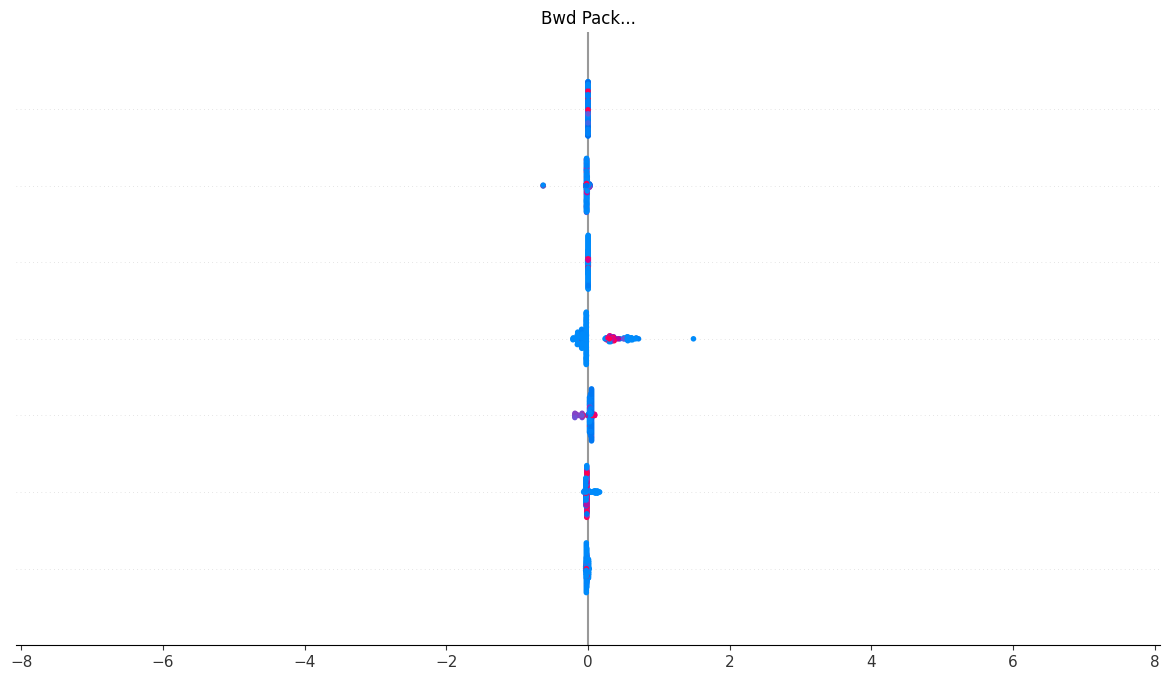


[SHAP] 正在生成 Bar Plot...
图表已保存至: xai_reports_tree/SHAP_Summary_Bar.png


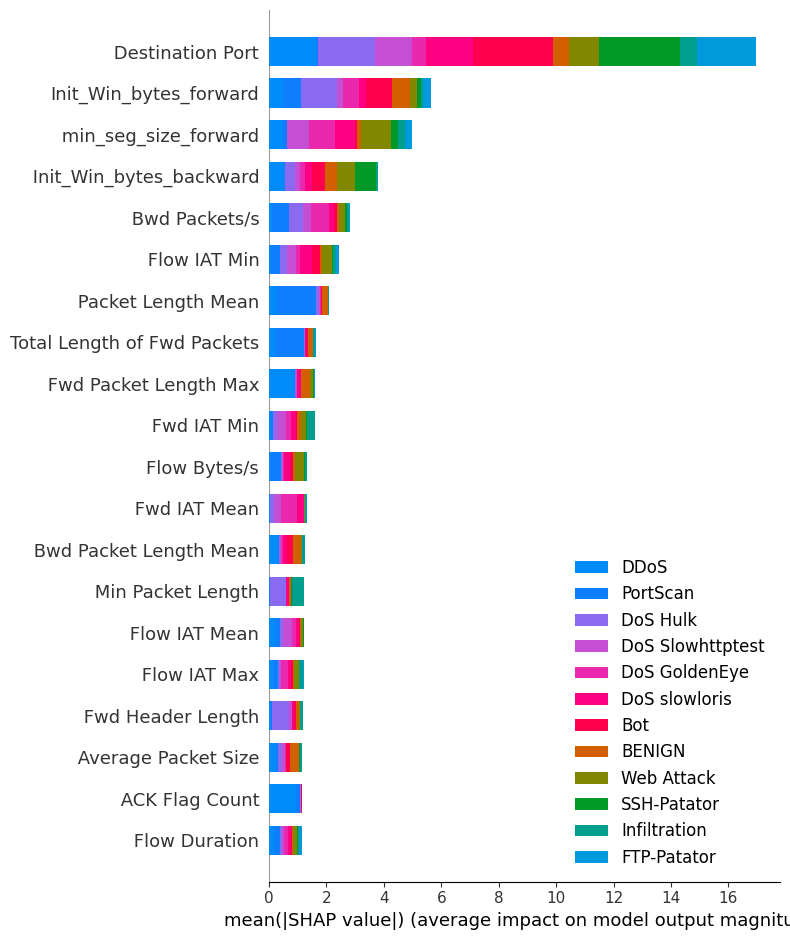


--- 正在分析模型预测结果 ---
总样本数: 565877; ✅ 正确: 565434; ❌ 错误: 443; 准确率: 99.92%

--- 将对前 3 个错误预测样本进行深度分析 ---

========================= 分析样本: Wrong Sample 33 (True Bot, Pred BENIGN) =========================
模型预测结果: 'BENIGN' (概率: 0.5655)

[SHAP] 正在生成 Waterfall Plot...
图表已保存至: xai_reports_tree/Wrong Sample 33 True Bot Pred BENIGN_SHAP_Waterfall.png


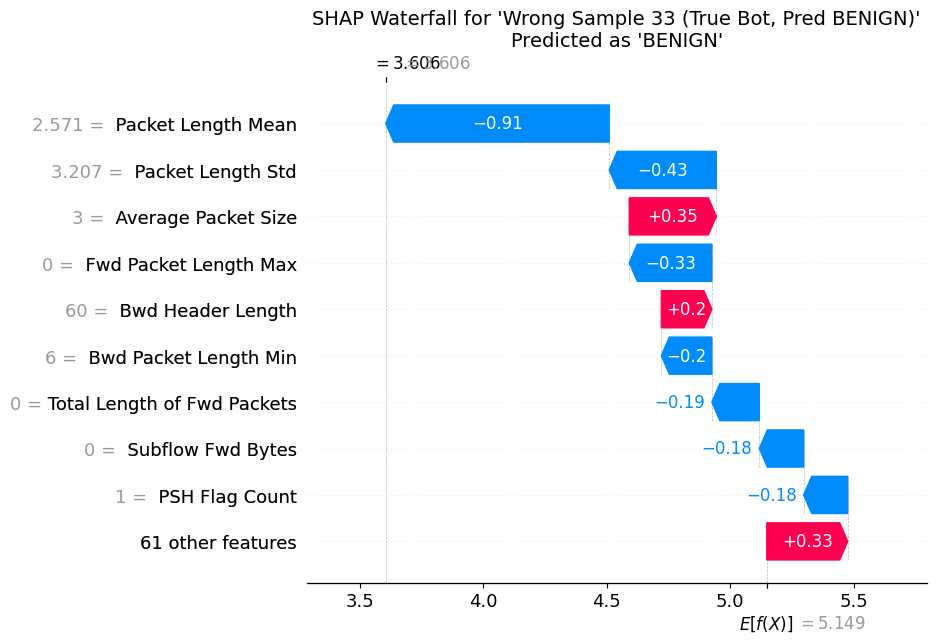


[SHAP] 正在生成 Force Plot (交互式)...



[LIME] 正在生成解释...
正在创建LIME TabularExplainer...
[LIME] 将为类别 ['BENIGN', 'Bot'] 生成解释。

[LIME] 可读性增强版文本摘要:



========================= 分析样本: Wrong Sample 208 (True FTP-Patator, Pred Web Attack) =========================
模型预测结果: 'Web Attack' (概率: 0.9957)

[SHAP] 正在生成 Waterfall Plot...
图表已保存至: xai_reports_tree/Wrong Sample 208 True FTP-Patator Pred Web Attack_SHAP_Waterfall.png


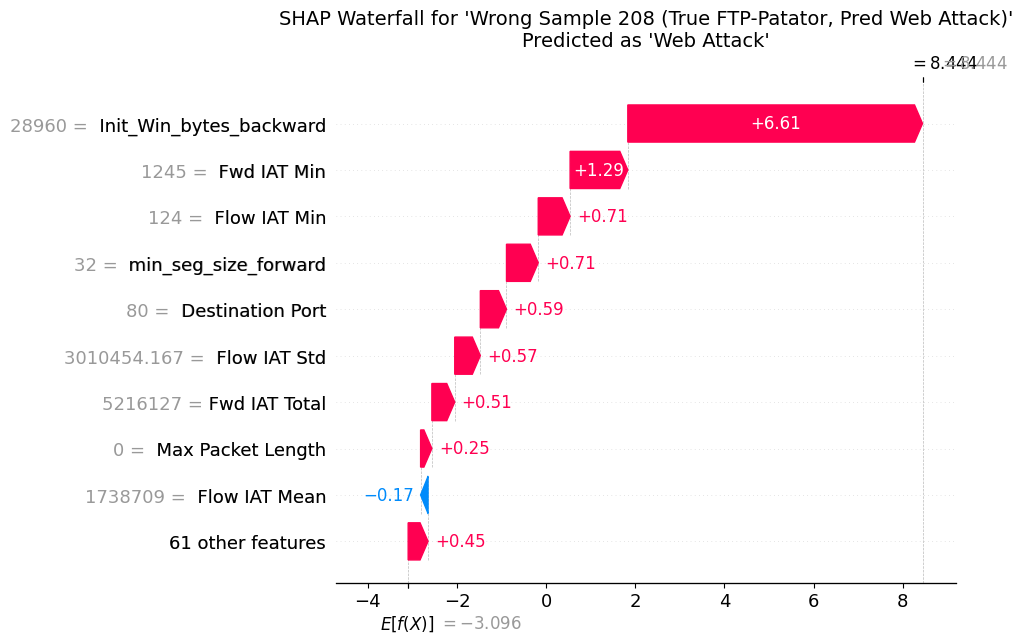


[SHAP] 正在生成 Force Plot (交互式)...



[LIME] 正在生成解释...
[LIME] 将为类别 ['FTP-Patator', 'Web Attack'] 生成解释。

[LIME] 可读性增强版文本摘要:



========================= 分析样本: Wrong Sample 420 (True Bot, Pred BENIGN) =========================
模型预测结果: 'BENIGN' (概率: 0.9936)

[SHAP] 正在生成 Waterfall Plot...
图表已保存至: xai_reports_tree/Wrong Sample 420 True Bot Pred BENIGN_SHAP_Waterfall.png


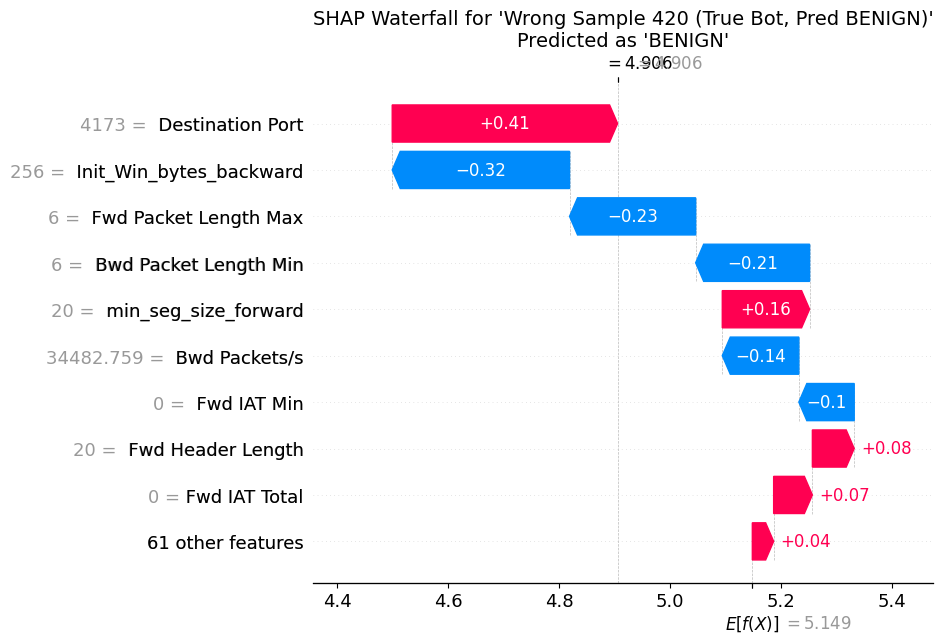


[SHAP] 正在生成 Force Plot (交互式)...



[LIME] 正在生成解释...
[LIME] 将为类别 ['BENIGN', 'Bot'] 生成解释。

[LIME] 可读性增强版文本摘要:



### 所有分析已完成！ ###


In [ ]:
shap.initjs()

# 3.2: 实例化新的TreeXAIAnalyzer
# 注意：我们不再传入scaler，因为我们没有使用它
tree_analyzer = TreeXAIAnalyzer(
    model=xgb_clf,
    X_train=X_train,
    class_names=le.classes_.tolist(),
    feature_names=features
    # scaler=None 是默认值，无需填写
)
print("树模型XAI分析器已准备就绪。")

# 3.3: 进行调用
# (A) 分析全局特征重要性
tree_analyzer.generate_shap_summary_plot(X_test, max_samples=200, save_plots_path="xai_reports_tree")

# (B) 分析错误预测的样本
tree_analyzer.analyze_wrong_predictions(X_test, y_test, max_samples=3, save_plots_path="xai_reports_tree")

print("\n### 所有分析已完成！ ###")